## Imports and utility functions


In [13]:


import numpy as np
import os
os.system('source /home/jackalak/heartbeat/cdf38_0-dist/bin/definitions.B')
os.environ["CDF_LIB"] = '/home/jackalak/heartbeat/cdf38_0-dist/lib'
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold

from pickle import dump
import joblib

# from keras import backend as K
import tensorflow.keras as k
from tensorflow.keras import utils, models, layers, optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf

from scipy.stats import gaussian_kde

from ovationpyme import ovation_prime
from ovationpyme import ovation_utilities

#from nasaomnireader import omnireader
from geospacepy import omnireader, special_datetime

#import time_hist2

#import netCDF4



In [14]:
print(k.__version__)
print(tf.__version__)


2.4.0
2.3.1


In [15]:

def NewellCF_calc(v,bz,by):
    # v expected in km/s
    # b's expected in nT    
    NCF = np.zeros_like(v)
    NCF.fill(np.nan)
    bt = np.sqrt(by**2 + bz**2)
    bztemp = bz
    bztemp[bz == 0] = .001
    #Caculate clock angle (theta_c = t_c)
    tc = np.arctan2(by,bztemp)
    neg_tc = bt*np.cos(tc)*bz < 0 
    tc[neg_tc] = tc[neg_tc] + np.pi
    sintc = np.abs(np.sin(tc/2.))
    NCF = (v**1.33333)*(sintc**2.66667)*(bt**0.66667)
    return NCF

def nearest(items, pivot):
    #return min(items, key=lambda x: abs(x - pivot))
    return np.argmin(abs(items - pivot))


def outlier_detect_and_replace(df,str_id,outlier_value):
    """This function takes a dataframe, finds any columns 
    matching 'str_id' in the provided dataframe, and replaces
    all values that exceed the 'outlier_value' with NaN"""
#     print('working on {} outlier detection and removal'.format(str_id))
#     print('outlier value = {}'.format(outlier_value))

    cols = [ col for col in df.columns if str_id in col]
#     print('will detect and replace for columns = {}'.format(cols))
    for i in cols:
        df[i][ df[i] > outlier_value ] = np.NaN

    return df

# Metrics defined by 2019 GNSS FDL team
def dynamic_range_and_mae_loss(y_true, y_pred):
    mae = k.losses.mean_absolute_error(y_true, y_pred)
    dynamic_range_true = k.backend.max(y_true) - k.backend.min(y_true)
    dynamic_range_pred = k.backend.max(y_pred) - k.backend.min(y_pred)
    dynamic_range_loss = k.backend.abs(dynamic_range_true - dynamic_range_pred)
    dynamic_range_loss = k.backend.mean(dynamic_range_loss)
    return mae + 0.1* dynamic_range_loss

def different_exponent(y_true, y_pred):
    # |x-y|^3 with dynamic range
    mae = k.backend.pow(k.backend.abs(y_true-y_pred),3)
    mae = k.backend.mean(mae)
    dynamic_range_true = k.backend.max(y_true) - k.backend.min(y_true)
    dynamic_range_pred = k.backend.max(y_pred) - k.backend.min(y_pred)
    dynamic_range_loss = dynamic_range_true - dynamic_range_pred
    dynamic_range_loss = k.backend.mean(dynamic_range_loss)
    return mae+ 0.1* dynamic_range_loss

def tilted_loss(q,y_true,y_pred):
    e = (y_true-y_pred)
    return k.backend.mean(k.backend.maximum(q*e, (q-1)*e), axis=-1)

# def plot_box_summary(df,save_location,save_filename):
# NOTE: now use %run box_plot_summary_function.ipynb for this functionality

In [16]:
%run standard_assessment_metrics_function.ipynb

In [17]:
DMSP_FIGURE_DIR = 'DMSPdata/figures/'
DMSP_DATA_DIR = 'DMSPdata/data/'
POLAR_VIS_DATA_DIR = 'POLAR_VISdata/POLAR_VIS_Jan_25_2000/'


In [18]:
eflux_threshold_quantile = 99.995
eflux_threshold = .99995

erg_eV_factor = (1.60218e-12)

## Prepare data for ML exploration (read in full DB created from standard_ML_DB_preparation.ipynb)


In [19]:
# file_load_df_cumulative = 'ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'
file_load_df_cumulative = '/home/jackalak/heartbeat/ParticlePrecipitation/ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv' #ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine_PCfixed.csv'
df_cumulative = pd.read_csv(os.path.join(DMSP_DATA_DIR,file_load_df_cumulative))
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)



In [20]:
df_cumulative.columns.to_list()

['SC_AACGM_LAT',
 'SC_AACGM_LTIME',
 'ELE_TOTAL_ENERGY_FLUX',
 'ELE_TOTAL_ENERGY_FLUX_STD',
 'ELE_AVG_ENERGY',
 'ELE_AVG_ENERGY_STD',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AE',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'vx',
 'psw',
 'borovsky',
 'newell',
 'F107_6hr',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AE_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'vx_6hr',
 'psw_6hr',
 'borovsky_6hr',
 'newell_6hr',
 'F107_5hr',
 'Bz_5hr',
 'By_5hr',
 'Bx_5hr',
 'AE_5hr',
 'AL_5hr',
 'AU_5hr',
 'SymH_5hr',
 'PC_5hr',
 'vsw_5hr',
 'vx_5hr',
 'psw_5hr',
 'borovsky_5hr',
 'newell_5hr',
 'F107_3hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AE_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'vx_3hr',
 'psw_3hr',
 'borovsky_3hr',
 'newell_3hr',
 'F107_1hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AE_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'vx_1hr',
 'psw_1hr',
 '

In [21]:
df_cumulative_no_cols_dropped = df_cumulative.copy()

In [22]:

# df_cumulative_LTIMEs = df_cumulative_no_cols_dropped['SC_AACGM_LTIME'].copy(deep=True)
# df_cumulative_STDs = df_cumulative_no_cols_dropped['ELE_TOTAL_ENERGY_FLUX_STD'].copy(deep=True)
df_cumulative_LTIMEs = df_cumulative['SC_AACGM_LTIME'].copy(deep=True)
df_cumulative_STDs = df_cumulative['ELE_TOTAL_ENERGY_FLUX_STD'].copy(deep=True)

# cols_to_drop = [c for c in df_cumulative.columns if ('SC_AACGM_LTIME'==c)]
# cols_to_drop = [c for c in df_cumulative.columns if ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop = [c for c in df_cumulative_no_cols_dropped.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('15min' in c)| ('5hr' in c) | ('newell' in c) | ('borovsky' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop = []

# Final selected set: RMM July 16, 2020
cols_to_drop = [c for c in df_cumulative.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('_5min'in c) | ('15min' in c)| ('5hr' in c) | ('F107_' in c) | ('vx' in c) | ('AE' in c) | ('newell' in c) | ('borovsky' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop = [c for c in df_cumulative.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('_5min'in c) | ('15min' in c)| ('5hr' in c) | ('newell' in c) | ('borovsky' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]


# df_cumulative = df_cumulative_no_cols_dropped.drop(columns=cols_to_drop)
df_cumulative = df_cumulative.drop(columns=cols_to_drop)


In [23]:
df_cumulative.columns.to_list()

['SC_AACGM_LAT',
 'ELE_TOTAL_ENERGY_FLUX',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'psw',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'psw_6hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'psw_3hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'psw_1hr',
 'Bz_45min',
 'By_45min',
 'Bx_45min',
 'AL_45min',
 'AU_45min',
 'SymH_45min',
 'PC_45min',
 'vsw_45min',
 'psw_45min',
 'Bz_30min',
 'By_30min',
 'Bx_30min',
 'AL_30min',
 'AU_30min',
 'SymH_30min',
 'PC_30min',
 'vsw_30min',
 'psw_30min',
 'Bz_10min',
 'By_10min',
 'Bx_10min',
 'AL_10min',
 'AU_10min',
 'SymH_10min',
 'PC_10min',
 'vsw_10min',
 'psw_10min']

In [24]:
print('number of input features total = {}'.format(df_cumulative.shape[1]))

number of input features total = 73


In [26]:
# Remove outliers
# idx_outliers = np.where( df_cumulative['ELE_TOTAL_ENERGY_FLUX'] > np.percentile(df_cumulative['ELE_TOTAL_ENERGY_FLUX'],99.995) )

print(df_cumulative.shape)
threshold_drop_val = np.percentile(df_cumulative['ELE_TOTAL_ENERGY_FLUX'],eflux_threshold_quantile)
# print('... dropping rows where total electron energy flux is greater than {:.4E} [eV/cm2/s/ster]'.format(threshold_drop_val))
# print('--------> number dropped = {}'.format(len( np.argwhere(df_cumulative['ELE_TOTAL_ENERGY_FLUX'] > threshold_drop_val) )))
df_cumulative_LTIMEs = df_cumulative_LTIMEs[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'] < threshold_drop_val) ]
df_cumulative_STDs = df_cumulative_STDs[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'] < threshold_drop_val) ]
df_cumulative = df_cumulative[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'] < threshold_drop_val) ]
print(df_cumulative.shape)

# np.where(df_cumulative['ELE_TOTAL_ENERGY_FLUX'] > np.percentile(df_cumulative['ELE_TOTAL_ENERGY_FLUX'],99.995))





(1947016, 73)
(1946918, 73)


In [27]:
print( 'number of input features = {}'.format( len(df_cumulative.columns.to_list()) ) )

df_cumulative.columns.to_list()

number of input features = 73


['SC_AACGM_LAT',
 'ELE_TOTAL_ENERGY_FLUX',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'psw',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'psw_6hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'psw_3hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'psw_1hr',
 'Bz_45min',
 'By_45min',
 'Bx_45min',
 'AL_45min',
 'AU_45min',
 'SymH_45min',
 'PC_45min',
 'vsw_45min',
 'psw_45min',
 'Bz_30min',
 'By_30min',
 'Bx_30min',
 'AL_30min',
 'AU_30min',
 'SymH_30min',
 'PC_30min',
 'vsw_30min',
 'psw_30min',
 'Bz_10min',
 'By_10min',
 'Bx_10min',
 'AL_10min',
 'AU_10min',
 'SymH_10min',
 'PC_10min',
 'vsw_10min',
 'psw_10min']

In [28]:
# Separate training and testing data
# mask_val = [(df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)]
mask_val = [ ((df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)) | 
             ((df_cumulative.index.year == 2000) & (df_cumulative.index.month == 1) & (df_cumulative.index.day == 25)) ]
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])
print('validation data shape = {}'.format(df_val.shape))
print('train data shape = {}'.format(df_train.shape))
print('NOTE: we will use CV on the train data below to define model training and testing data,\n  so have called the withheld data *validation* data here')

# Construct X and y
feature_cols = [c for c in df_cumulative.columns if not 'ELE' in c]


X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
# scaler_X = preprocessing.MinMaxScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()

validation data shape = (55210, 73)
train data shape = (1838185, 73)
NOTE: we will use CV on the train data below to define model training and testing data,
  so have called the withheld data *validation* data here


In [29]:
y_train = y_train * np.pi
y_val = y_val * np.pi
print('NOTE: removing the steradian from the DMSP data BEFORE training/n/n    ----> RMM May 28, 2020')

y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)


y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

NOTE: removing the steradian from the DMSP data BEFORE training/n/n    ----> RMM May 28, 2020


In [30]:
# Read in OVATION Prime model data at DMSP validation data locations 
#      (created by RMM using 'OVATIONprime_atDMSPvalidationData.py' on 
#       May 22-24, 2020 using deepsun computing)
y_val_ovation = pd.read_csv(os.path.join(DMSP_DATA_DIR,'OVATIONprime_atDMSP_F16_2010_locations.csv'))
y_val_ovation = y_val_ovation.rename(columns={'Unnamed: 0':'Datetimes'})
y_val_ovation = y_val_ovation.set_index('Datetimes')
y_val_ovation.index = pd.to_datetime(y_val_ovation.index)


In [31]:
print('number of zero validation data points in OVATION = {}'.format(len(y_val_ovation['model value'][y_val_ovation['model value'] == 0.])))
      
      

number of zero validation data points in OVATION = 10893


In [32]:
y_val_ovation['model value'][y_val_ovation['model value'] == 0.] = 0.0001
y_val_ovation['model value log10(ev/cm2/s)'] = np.log10( y_val_ovation['model value']/(1.60218e-12) )

y_val_ovation = y_val_ovation.reindex(y_val_log.index)


## Interrogate the model

### Pre-step: Set constants and model construction

In [33]:
random_seed = 7

# mlepochs = 35
# batch_size = 400
# Dropout = 0.2
# learning_rate = 0.005

# JZ optimal model #3
mlepochs = 1000
batch_size = 32768
Dropout = 0.1
learning_rate = 0.001


    Working on CV fold = 0
    ----> Indices
      1987-01-12 12:57:00
      2010-12-15 05:54:00
    Working on CV fold = 1
    ----> Indices
      2001-09-20 22:13:00
      2011-05-23 01:41:00
    Working on CV fold = 2
    ----> Indices
      2001-12-01 04:24:00
      2011-06-26 14:09:00
    Working on CV fold = 3
    ----> Indices
      2002-03-29 20:14:00
      2012-02-03 12:33:00
    Working on CV fold = 4
    ----> Indices
      2003-10-23 03:39:00
      2012-12-21 00:38:00
    Working on CV fold = 5
    ----> Indices
      2004-07-12 14:00:00
      2013-01-28 19:12:00
    Working on CV fold = 6
    ----> Indices
      2005-11-11 21:44:00
      2013-11-21 06:35:00
    Working on CV fold = 7
    ----> Indices
      2005-11-14 04:15:00
      2013-09-27 14:08:00
    Working on CV fold = 8
    ----> Indices
      2006-01-09 01:41:00
      2014-09-28 21:33:00
    Working on CV fold = 9
    ----> Indices
      2007-06-27 07:11:00
      2014-12-31 22:54:00


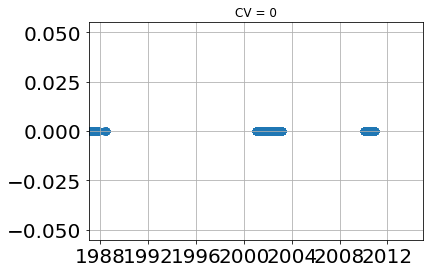

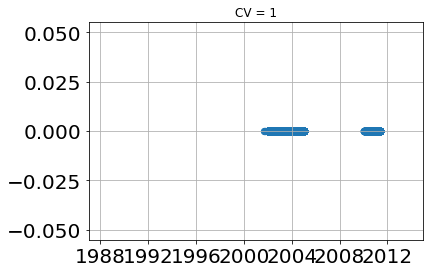

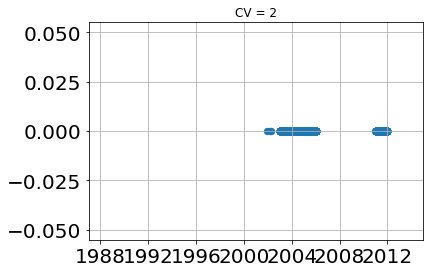

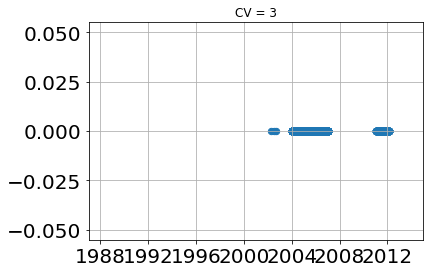

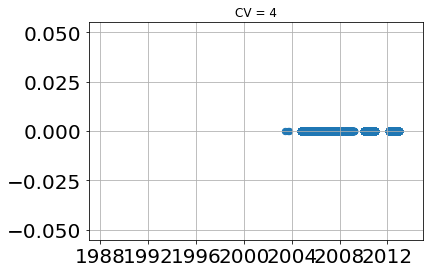

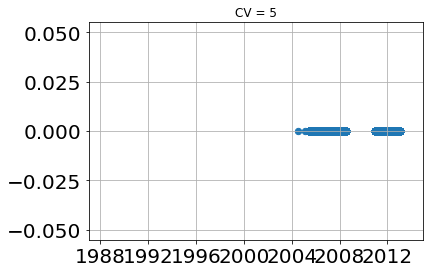

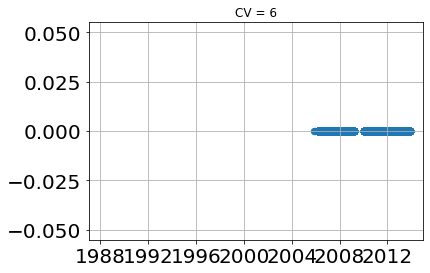

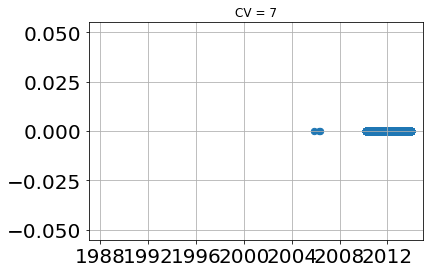

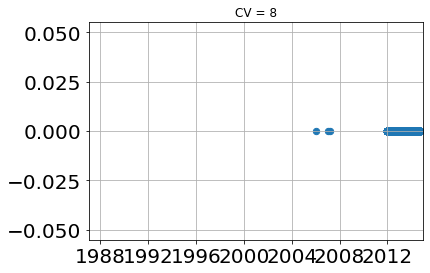

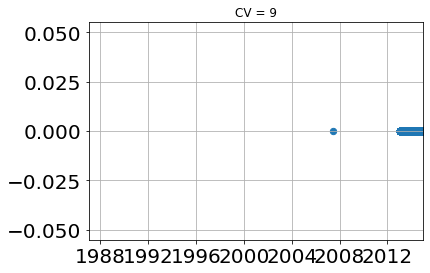

In [34]:
# Visualizing the stratified data samples

from sklearn.model_selection import StratifiedKFold
n_splits = 10
bins = np.linspace(0, 15, 15)
y_train_binned = np.digitize(y_train_log,
                             bins)

iteration = 0
skf = StratifiedKFold(n_splits=n_splits,shuffle=False)# random_state=random_seed, shuffle=False)
for train_index, test_index in skf.split(X_train.values, y_train_binned):
    print('    Working on CV fold = {}'.format(iteration))

    print('    ----> Indices\n      {}\n      {}'.format(y_train_log.index[test_index[0]],y_train_log.index[test_index[-1]]))
    print('===================')
#     plt.figure()
#     plt.hist(y_train_log[train_index].values)
#     plt.title('CV = '+str(iteration))

    plt.figure()
    plt.scatter(X_train.index[test_index],
                np.zeros(len(test_index)),
                s=40)
    plt.title('CV = '+str(iteration))
    plt.grid(True)
    plt.xlim(X_train.index[0],X_train.index[-1])
    iteration += 1

### Fit and compare cross-fold models 

In [35]:
# Create digitized y for stratified k-fold
from sklearn.model_selection import StratifiedKFold
n_splits = 10
bins = np.linspace(0, 15, 15)
y_train_binned = np.digitize(y_train_log,
                             bins)

df_CV_columns = ['CV'+str(x) for x in range(n_splits)]
df_CV = pd.DataFrame(columns=df_CV_columns,index=y_val_log.index)

df_metrics_CV_columns = ['iteration','MAE','MSE','RMSE','RAE','RSE','RSQ','linear slope','linear intercept']
df_metrics_CV_test = pd.DataFrame(columns=df_metrics_CV_columns,index=np.arange(n_splits))
df_metrics_CV_val = pd.DataFrame(columns=df_metrics_CV_columns,index=np.arange(n_splits))


# CREATE CROSS-VALIDATION SPLITS
iteration = 0
skf = StratifiedKFold(n_splits=n_splits, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X_train.values, y_train_binned):
    print('    Working on CV fold = {}'.format(iteration))

    
    # CREATE THE MODEL
#     model = k.models.Sequential()
#     model.add(k.layers.Dense(128, input_dim=X_train_scaled.shape[1], activation='selu'))
#     model.add(k.layers.AlphaDropout(Dropout))
#     model.add(k.layers.Dense(16, activation='selu'))
#     model.add(k.layers.Dense(4, activation='selu'))    
#     model.add(k.layers.Dense(1, activation='linear'))

    # JZ optimal model #3
    model = k.models.Sequential()
    model.add(k.layers.Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(k.layers.Dropout(Dropout))
    model.add(k.layers.Dense(64, activation='relu'))
    model.add(k.layers.Dense(32,activation='relu'))
    model.add(k.layers.Dense(256,activation='relu'))
    model.add(k.layers.Dense(1024,activation='relu'))
    model.add(k.layers.Dense(256, activation='relu'))
    model.add(k.layers.Dense(32, activation='relu'))
    model.add(k.layers.Dense(4, activation='relu'))    
    model.add(k.layers.Dense(1, activation='linear'))
    
    # FIT THE MODEL
    model.compile(loss='mse',
                  optimizer = k.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['logcosh','mse','mae'])
    history = model.fit(X_train_scaled[train_index],
                        y_train_log[train_index].values, 
                        epochs=mlepochs, 
                        batch_size=batch_size,
                        validation_data=(X_train_scaled[test_index], y_train_log[test_index].values), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  restore_best_weights=True,
             patience=100)])

    # PREDICT ON THE TEST AND VALIDATION DATA
    y_predict_test = model.predict(X_train_scaled[test_index])
    y_predict_val = model.predict(X_val_scaled)
    
    df_CV.iloc[:,iteration] = y_predict_val

    # CALCULATE METRICS
    MAE_test, MSE_test, RMSE_test, RAE_test, RSE_test, RSQ_test, lin_slope_test, lin_intercept_test = model_eval(y_train_log[test_index].values,y_predict_test)
    MAE_val, MSE_val, RMSE_val, RAE_val, RSE_val, RSQ_val, lin_slope_val, lin_intercept_val = model_eval(y_val_log.values,y_predict_val)

    # SAVE METRICS TO DATAFRAMES
    df_metrics_CV_test.iloc[iteration,:] = [iteration, MAE_test, MSE_test, RMSE_test, RAE_test, RSE_test, RSQ_test, lin_slope_test, lin_intercept_test]
    df_metrics_CV_val.iloc[iteration,:] = [iteration, MAE_val, MSE_val, RMSE_val, RAE_val, RSE_val, RSQ_val, lin_slope_val, lin_intercept_val]

    iteration += 1
        
        
# df_metrics_CV_test.to_csv(os.path.join(DMSP_DATA_DIR,'selfNormalizedModel_cv_results_testMetrics.csv'))
# df_metrics_CV_val.to_csv(os.path.join(DMSP_DATA_DIR,'selfNormalizedModel_cv_results_validationMetrics.csv'))
# df_CV.to_csv(os.path.join(DMSP_DATA_DIR,'selfNormalizedModel_cv_results_validationPredictions.csv'))
df_metrics_CV_test.to_csv(os.path.join(DMSP_DATA_DIR,'JZ_network3_Model_cv_results_testMetrics.csv'))
df_metrics_CV_val.to_csv(os.path.join(DMSP_DATA_DIR,'JZ_network3_Model_cv_results_validationMetrics.csv'))
df_CV.to_csv(os.path.join(DMSP_DATA_DIR,'JZ_network3_Model_cv_results_validationPredictions.csv'))
    
        
        
        

    Working on CV fold = 0
Epoch 1/1000
51/51 [==============================] - 1s 25ms/step - loss: 20.4857 - logcosh: 2.6271 - mse: 20.4857 - mae: 3.2170 - val_loss: 4.1991 - val_logcosh: 1.0839 - val_mse: 4.1991 - val_mae: 1.6295
Epoch 2/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.6807 - logcosh: 0.5528 - mse: 1.6807 - mae: 1.0180 - val_loss: 1.2813 - val_logcosh: 0.4540 - val_mse: 1.2813 - val_mae: 0.8950
Epoch 3/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.2511 - logcosh: 0.4485 - mse: 1.2511 - mae: 0.8942 - val_loss: 1.1669 - val_logcosh: 0.4263 - val_mse: 1.1669 - val_mae: 0.8648
Epoch 4/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.1816 - logcosh: 0.4290 - mse: 1.1816 - mae: 0.8693 - val_loss: 1.0878 - val_logcosh: 0.4024 - val_mse: 1.0878 - val_mae: 0.8324
Epoch 5/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.1087 - logcosh: 0.4076 - mse: 1.1087 - mae: 0.8421 - val_loss: 1.0043 - va

Epoch 41/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4990 - logcosh: 0.1983 - mse: 0.4990 - mae: 0.5205 - val_loss: 0.4672 - val_logcosh: 0.1879 - val_mse: 0.4672 - val_mae: 0.5099
Epoch 42/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4978 - logcosh: 0.1978 - mse: 0.4978 - mae: 0.5194 - val_loss: 0.4656 - val_logcosh: 0.1873 - val_mse: 0.4656 - val_mae: 0.5085
Epoch 43/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4987 - logcosh: 0.1981 - mse: 0.4987 - mae: 0.5200 - val_loss: 0.5049 - val_logcosh: 0.2015 - val_mse: 0.5049 - val_mae: 0.5256
Epoch 44/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4929 - logcosh: 0.1960 - mse: 0.4929 - mae: 0.5162 - val_loss: 0.4677 - val_logcosh: 0.1878 - val_mse: 0.4677 - val_mae: 0.5052
Epoch 45/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4930 - logcosh: 0.1960 - mse: 0.4930 - mae: 0.5160 - val_loss: 0.4874 - val_logcosh: 0.1949 - val_

Epoch 81/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4381 - logcosh: 0.1744 - mse: 0.4381 - mae: 0.4721 - val_loss: 0.4625 - val_logcosh: 0.1860 - val_mse: 0.4625 - val_mae: 0.5110
Epoch 82/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4373 - logcosh: 0.1740 - mse: 0.4373 - mae: 0.4712 - val_loss: 0.4741 - val_logcosh: 0.1903 - val_mse: 0.4741 - val_mae: 0.5050
Epoch 83/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4353 - logcosh: 0.1733 - mse: 0.4353 - mae: 0.4697 - val_loss: 0.4563 - val_logcosh: 0.1829 - val_mse: 0.4563 - val_mae: 0.4989
Epoch 84/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4431 - logcosh: 0.1763 - mse: 0.4431 - mae: 0.4761 - val_loss: 0.4497 - val_logcosh: 0.1807 - val_mse: 0.4497 - val_mae: 0.4896
Epoch 85/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4329 - logcosh: 0.1724 - mse: 0.4329 - mae: 0.4677 - val_loss: 0.4589 - val_logcosh: 0.1846 - val_

Epoch 121/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4139 - logcosh: 0.1652 - mse: 0.4139 - mae: 0.4541 - val_loss: 0.4335 - val_logcosh: 0.1744 - val_mse: 0.4335 - val_mae: 0.4816
Epoch 122/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4154 - logcosh: 0.1658 - mse: 0.4154 - mae: 0.4555 - val_loss: 0.4403 - val_logcosh: 0.1772 - val_mse: 0.4403 - val_mae: 0.4820
Epoch 123/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4113 - logcosh: 0.1643 - mse: 0.4113 - mae: 0.4520 - val_loss: 0.4348 - val_logcosh: 0.1750 - val_mse: 0.4348 - val_mae: 0.4849
Epoch 124/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4113 - logcosh: 0.1642 - mse: 0.4113 - mae: 0.4520 - val_loss: 0.4370 - val_logcosh: 0.1757 - val_mse: 0.4370 - val_mae: 0.4812
Epoch 125/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4106 - logcosh: 0.1640 - mse: 0.4106 - mae: 0.4514 - val_loss: 0.4488 - val_logcosh: 0.1803 -

51/51 [==============================] - 1s 22ms/step - loss: 0.3970 - logcosh: 0.1590 - mse: 0.3970 - mae: 0.4419 - val_loss: 0.4333 - val_logcosh: 0.1744 - val_mse: 0.4333 - val_mae: 0.4777
Epoch 161/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3968 - logcosh: 0.1589 - mse: 0.3968 - mae: 0.4417 - val_loss: 0.4410 - val_logcosh: 0.1773 - val_mse: 0.4410 - val_mae: 0.4810
Epoch 162/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3952 - logcosh: 0.1582 - mse: 0.3952 - mae: 0.4402 - val_loss: 0.5001 - val_logcosh: 0.2000 - val_mse: 0.5001 - val_mae: 0.5209
Epoch 163/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3994 - logcosh: 0.1599 - mse: 0.3994 - mae: 0.4444 - val_loss: 0.4396 - val_logcosh: 0.1765 - val_mse: 0.4396 - val_mae: 0.4798
Epoch 164/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3978 - logcosh: 0.1593 - mse: 0.3978 - mae: 0.4428 - val_loss: 0.4372 - val_logcosh: 0.1758 - val_mse: 0.437

Epoch 200/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3831 - logcosh: 0.1539 - mse: 0.3831 - mae: 0.4321 - val_loss: 0.4452 - val_logcosh: 0.1780 - val_mse: 0.4452 - val_mae: 0.4916
Epoch 201/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.3854 - logcosh: 0.1548 - mse: 0.3854 - mae: 0.4342 - val_loss: 0.4319 - val_logcosh: 0.1732 - val_mse: 0.4319 - val_mae: 0.4748
Epoch 202/1000
51/51 [==============================] - 1s 26ms/step - loss: 0.3846 - logcosh: 0.1544 - mse: 0.3846 - mae: 0.4333 - val_loss: 0.4642 - val_logcosh: 0.1861 - val_mse: 0.4642 - val_mae: 0.4944
Epoch 203/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3845 - logcosh: 0.1544 - mse: 0.3845 - mae: 0.4332 - val_loss: 0.4365 - val_logcosh: 0.1750 - val_mse: 0.4365 - val_mae: 0.4810
Epoch 204/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3841 - logcosh: 0.1543 - mse: 0.3841 - mae: 0.4333 - val_loss: 0.4371 - val_logcosh: 0.1751 -

51/51 [==============================] - 1s 21ms/step - loss: 0.3767 - logcosh: 0.1516 - mse: 0.3767 - mae: 0.4288 - val_loss: 0.4391 - val_logcosh: 0.1755 - val_mse: 0.4391 - val_mae: 0.4831
Epoch 240/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3743 - logcosh: 0.1507 - mse: 0.3743 - mae: 0.4266 - val_loss: 0.4463 - val_logcosh: 0.1786 - val_mse: 0.4463 - val_mae: 0.4827
Epoch 241/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3785 - logcosh: 0.1524 - mse: 0.3785 - mae: 0.4306 - val_loss: 0.4641 - val_logcosh: 0.1855 - val_mse: 0.4641 - val_mae: 0.4930
Epoch 242/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3755 - logcosh: 0.1512 - mse: 0.3755 - mae: 0.4278 - val_loss: 0.4400 - val_logcosh: 0.1762 - val_mse: 0.4400 - val_mae: 0.4812
Epoch 243/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3766 - logcosh: 0.1516 - mse: 0.3766 - mae: 0.4289 - val_loss: 0.4407 - val_logcosh: 0.1763 - val_mse: 0.440

51/51 [==============================] - 1s 21ms/step - loss: 67.3163 - logcosh: 7.4227 - mse: 67.3163 - mae: 8.1159 - val_loss: 67.5959 - val_logcosh: 7.4445 - val_mse: 67.5959 - val_mae: 8.1376
Epoch 32/1000
51/51 [==============================] - 1s 21ms/step - loss: 66.5445 - logcosh: 7.3750 - mse: 66.5445 - mae: 8.0682 - val_loss: 66.8227 - val_logcosh: 7.3968 - val_mse: 66.8227 - val_mae: 8.0900
Epoch 33/1000
51/51 [==============================] - 1s 21ms/step - loss: 65.7786 - logcosh: 7.3274 - mse: 65.7786 - mae: 8.0206 - val_loss: 66.0555 - val_logcosh: 7.3493 - val_mse: 66.0555 - val_mae: 8.0424
Epoch 34/1000
51/51 [==============================] - 1s 21ms/step - loss: 65.0186 - logcosh: 7.2799 - mse: 65.0186 - mae: 7.9731 - val_loss: 65.2941 - val_logcosh: 7.3018 - val_mse: 65.2941 - val_mae: 7.9949
Epoch 35/1000
51/51 [==============================] - 1s 21ms/step - loss: 64.2644 - logcosh: 7.2325 - mse: 64.2644 - mae: 7.9256 - val_loss: 64.5385 - val_logcosh: 7.2544 -

51/51 [==============================] - 1s 21ms/step - loss: 41.2680 - logcosh: 5.6171 - mse: 41.2680 - mae: 6.3102 - val_loss: 41.4866 - val_logcosh: 5.6402 - val_mse: 41.4866 - val_mae: 6.3334
Epoch 71/1000
51/51 [==============================] - 1s 21ms/step - loss: 40.7019 - logcosh: 5.5721 - mse: 40.7019 - mae: 6.2652 - val_loss: 40.9188 - val_logcosh: 5.5953 - val_mse: 40.9188 - val_mae: 6.2884
Epoch 72/1000
51/51 [==============================] - 1s 21ms/step - loss: 40.1406 - logcosh: 5.5271 - mse: 40.1406 - mae: 6.2203 - val_loss: 40.3558 - val_logcosh: 5.5503 - val_mse: 40.3558 - val_mae: 6.2435
Epoch 73/1000
51/51 [==============================] - 1s 21ms/step - loss: 39.5840 - logcosh: 5.4822 - mse: 39.5840 - mae: 6.1754 - val_loss: 39.7975 - val_logcosh: 5.5055 - val_mse: 39.7975 - val_mae: 6.1986
Epoch 74/1000
51/51 [==============================] - 1s 21ms/step - loss: 39.0322 - logcosh: 5.4374 - mse: 39.0322 - mae: 6.1305 - val_loss: 39.2440 - val_logcosh: 5.4606 -

51/51 [==============================] - 1s 22ms/step - loss: 22.5910 - logcosh: 3.9055 - mse: 22.5910 - mae: 4.5981 - val_loss: 22.7415 - val_logcosh: 3.9298 - val_mse: 22.7415 - val_mae: 4.6224
Epoch 110/1000
51/51 [==============================] - 1s 21ms/step - loss: 22.2004 - logcosh: 3.8629 - mse: 22.2004 - mae: 4.5554 - val_loss: 22.3491 - val_logcosh: 3.8872 - val_mse: 22.3491 - val_mae: 4.5797
Epoch 111/1000
51/51 [==============================] - 1s 21ms/step - loss: 21.8140 - logcosh: 3.8203 - mse: 21.8140 - mae: 4.5128 - val_loss: 21.9610 - val_logcosh: 3.8446 - val_mse: 21.9610 - val_mae: 4.5372
Epoch 112/1000
51/51 [==============================] - 1s 22ms/step - loss: 21.4318 - logcosh: 3.7778 - mse: 21.4318 - mae: 4.4702 - val_loss: 21.5771 - val_logcosh: 3.8022 - val_mse: 21.5771 - val_mae: 4.4947
Epoch 113/1000
51/51 [==============================] - 1s 21ms/step - loss: 21.0540 - logcosh: 3.7354 - mse: 21.0540 - mae: 4.4278 - val_loss: 21.1975 - val_logcosh: 3.75

Epoch 148/1000
51/51 [==============================] - 2s 38ms/step - loss: 10.3976 - logcosh: 2.3123 - mse: 10.3976 - mae: 2.9915 - val_loss: 10.4803 - val_logcosh: 2.3369 - val_mse: 10.4803 - val_mae: 3.0175
Epoch 149/1000
51/51 [==============================] - 2s 39ms/step - loss: 10.1637 - logcosh: 2.2741 - mse: 10.1637 - mae: 2.9521 - val_loss: 10.2447 - val_logcosh: 2.2986 - val_mse: 10.2447 - val_mae: 2.9782
Epoch 150/1000
51/51 [==============================] - 2s 39ms/step - loss: 9.9336 - logcosh: 2.2361 - mse: 9.9336 - mae: 2.9129 - val_loss: 10.0128 - val_logcosh: 2.2605 - val_mse: 10.0128 - val_mae: 2.9390
Epoch 151/1000
51/51 [==============================] - 2s 40ms/step - loss: 9.7072 - logcosh: 2.1982 - mse: 9.7072 - mae: 2.8737 - val_loss: 9.7848 - val_logcosh: 2.2226 - val_mse: 9.7848 - val_mae: 2.8999
Epoch 152/1000
51/51 [==============================] - 2s 39ms/step - loss: 9.4845 - logcosh: 2.1606 - mse: 9.4845 - mae: 2.8347 - val_loss: 9.5603 - val_logcosh

51/51 [==============================] - 2s 39ms/step - loss: 3.8819 - logcosh: 1.0474 - mse: 3.8819 - mae: 1.5907 - val_loss: 3.9000 - val_logcosh: 1.0596 - val_mse: 3.9000 - val_mae: 1.6102
Epoch 188/1000
51/51 [==============================] - 2s 39ms/step - loss: 3.7794 - logcosh: 1.0238 - mse: 3.7794 - mae: 1.5614 - val_loss: 3.7960 - val_logcosh: 1.0353 - val_mse: 3.7960 - val_mae: 1.5796
Epoch 189/1000
51/51 [==============================] - 2s 38ms/step - loss: 3.6798 - logcosh: 1.0007 - mse: 3.6798 - mae: 1.5328 - val_loss: 3.6948 - val_logcosh: 1.0116 - val_mse: 3.6948 - val_mae: 1.5496
Epoch 190/1000
51/51 [==============================] - 2s 39ms/step - loss: 3.5830 - logcosh: 0.9783 - mse: 3.5830 - mae: 1.5048 - val_loss: 3.5965 - val_logcosh: 0.9885 - val_mse: 3.5965 - val_mae: 1.5201
Epoch 191/1000
51/51 [==============================] - 2s 39ms/step - loss: 3.4891 - logcosh: 0.9564 - mse: 3.4891 - mae: 1.4774 - val_loss: 3.5010 - val_logcosh: 0.9660 - val_mse: 3.501

Epoch 227/1000
51/51 [==============================] - 2s 38ms/step - loss: 1.6586 - logcosh: 0.5421 - mse: 1.6586 - mae: 0.9725 - val_loss: 1.6191 - val_logcosh: 0.5268 - val_mse: 1.6191 - val_mae: 0.9453
Epoch 228/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.6407 - logcosh: 0.5390 - mse: 1.6407 - mae: 0.9712 - val_loss: 1.6000 - val_logcosh: 0.5231 - val_mse: 1.6000 - val_mae: 0.9420
Epoch 229/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.6240 - logcosh: 0.5361 - mse: 1.6240 - mae: 0.9704 - val_loss: 1.5821 - val_logcosh: 0.5197 - val_mse: 1.5821 - val_mae: 0.9393
Epoch 230/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.6084 - logcosh: 0.5336 - mse: 1.6084 - mae: 0.9698 - val_loss: 1.5654 - val_logcosh: 0.5167 - val_mse: 1.5654 - val_mae: 0.9370
Epoch 231/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.5939 - logcosh: 0.5312 - mse: 1.5939 - mae: 0.9697 - val_loss: 1.5497 - val_logcosh: 0.5139 -

51/51 [==============================] - 2s 39ms/step - loss: 1.4494 - logcosh: 0.5227 - mse: 1.4494 - mae: 1.0129 - val_loss: 1.3802 - val_logcosh: 0.4962 - val_mse: 1.3802 - val_mae: 0.9670
Epoch 267/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4493 - logcosh: 0.5229 - mse: 1.4493 - mae: 1.0135 - val_loss: 1.3798 - val_logcosh: 0.4963 - val_mse: 1.3798 - val_mae: 0.9676
Epoch 268/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4491 - logcosh: 0.5230 - mse: 1.4491 - mae: 1.0141 - val_loss: 1.3795 - val_logcosh: 0.4964 - val_mse: 1.3795 - val_mae: 0.9682
Epoch 269/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4490 - logcosh: 0.5232 - mse: 1.4490 - mae: 1.0146 - val_loss: 1.3792 - val_logcosh: 0.4966 - val_mse: 1.3792 - val_mae: 0.9687
Epoch 270/1000
51/51 [==============================] - 2s 38ms/step - loss: 1.4490 - logcosh: 0.5234 - mse: 1.4490 - mae: 1.0151 - val_loss: 1.3789 - val_logcosh: 0.4967 - val_mse: 1.378

Epoch 306/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0188 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9726
Epoch 307/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0188 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9726
Epoch 308/1000
51/51 [==============================] - 2s 38ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0189 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9726
Epoch 309/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0189 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9726
Epoch 310/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0189 - val_loss: 1.3772 - val_logcosh: 0.4975 -

51/51 [==============================] - 2s 39ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0189 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9726
Epoch 346/1000
51/51 [==============================] - 2s 38ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0188 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9725
Epoch 347/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0188 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9726
Epoch 348/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0188 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9726
Epoch 349/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0189 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.377

Epoch 385/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0187 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9727
Epoch 386/1000
51/51 [==============================] - 2s 38ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0190 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9726
Epoch 387/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0189 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9725
Epoch 388/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0189 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9725
Epoch 389/1000
51/51 [==============================] - 2s 38ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0188 - val_loss: 1.3772 - val_logcosh: 0.4975 -

51/51 [==============================] - 2s 38ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0191 - val_loss: 1.3773 - val_logcosh: 0.4974 - val_mse: 1.3773 - val_mae: 0.9725
Epoch 425/1000
51/51 [==============================] - 2s 38ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0187 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9727
Epoch 426/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0189 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9727
Epoch 427/1000
51/51 [==============================] - 2s 38ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0187 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9726
Epoch 428/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0190 - val_loss: 1.3774 - val_logcosh: 0.4973 - val_mse: 1.377

Epoch 464/1000
51/51 [==============================] - 2s 38ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0188 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9726
Epoch 465/1000
51/51 [==============================] - 2s 38ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0188 - val_loss: 1.3773 - val_logcosh: 0.4974 - val_mse: 1.3773 - val_mae: 0.9724
Epoch 466/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0188 - val_loss: 1.3771 - val_logcosh: 0.4975 - val_mse: 1.3771 - val_mae: 0.9728
Epoch 467/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0188 - val_loss: 1.3773 - val_logcosh: 0.4974 - val_mse: 1.3773 - val_mae: 0.9725
Epoch 468/1000
51/51 [==============================] - 2s 38ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0187 - val_loss: 1.3771 - val_logcosh: 0.4975 -

51/51 [==============================] - 2s 38ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0188 - val_loss: 1.3771 - val_logcosh: 0.4975 - val_mse: 1.3771 - val_mae: 0.9728
Epoch 504/1000
51/51 [==============================] - 2s 38ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0190 - val_loss: 1.3773 - val_logcosh: 0.4974 - val_mse: 1.3773 - val_mae: 0.9724
Epoch 505/1000
51/51 [==============================] - 2s 39ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0188 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9727
Epoch 506/1000
51/51 [==============================] - 2s 38ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0189 - val_loss: 1.3775 - val_logcosh: 0.4973 - val_mse: 1.3775 - val_mae: 0.9719
Epoch 507/1000
51/51 [==============================] - 2s 38ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0189 - val_loss: 1.3774 - val_logcosh: 0.4973 - val_mse: 1.377

Epoch 543/1000
51/51 [==============================] - 1s 24ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0191 - val_loss: 1.3774 - val_logcosh: 0.4974 - val_mse: 1.3774 - val_mae: 0.9723
Epoch 544/1000
51/51 [==============================] - 1s 24ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0187 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9726
Epoch 545/1000
51/51 [==============================] - 1s 24ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0188 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9726
Epoch 546/1000
51/51 [==============================] - 1s 24ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0190 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9725
Epoch 547/1000
51/51 [==============================] - 1s 24ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0188 - val_loss: 1.3772 - val_logcosh: 0.4975 -

51/51 [==============================] - 1s 20ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0188 - val_loss: 1.3771 - val_logcosh: 0.4976 - val_mse: 1.3771 - val_mae: 0.9729
Epoch 583/1000
51/51 [==============================] - 1s 20ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0187 - val_loss: 1.3771 - val_logcosh: 0.4975 - val_mse: 1.3771 - val_mae: 0.9728
Epoch 584/1000
51/51 [==============================] - 1s 21ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0189 - val_loss: 1.3771 - val_logcosh: 0.4975 - val_mse: 1.3771 - val_mae: 0.9728
Epoch 585/1000
51/51 [==============================] - 1s 20ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0189 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9726
Epoch 586/1000
51/51 [==============================] - 1s 21ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0187 - val_loss: 1.3771 - val_logcosh: 0.4975 - val_mse: 1.377

Epoch 622/1000
51/51 [==============================] - 1s 20ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0189 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9727
Epoch 623/1000
51/51 [==============================] - 1s 20ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0189 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9726
Epoch 624/1000
51/51 [==============================] - 1s 20ms/step - loss: 1.4487 - logcosh: 0.5246 - mse: 1.4487 - mae: 1.0188 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9727
Epoch 625/1000
51/51 [==============================] - 1s 21ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0189 - val_loss: 1.3772 - val_logcosh: 0.4975 - val_mse: 1.3772 - val_mae: 0.9727
Epoch 626/1000
51/51 [==============================] - 1s 21ms/step - loss: 1.4487 - logcosh: 0.5247 - mse: 1.4487 - mae: 1.0189 - val_loss: 1.3773 - val_logcosh: 0.4974 -

Epoch 17/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.5752 - logcosh: 0.2262 - mse: 0.5752 - mae: 0.5693 - val_loss: 0.5377 - val_logcosh: 0.2118 - val_mse: 0.5377 - val_mae: 0.5434
Epoch 18/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.5670 - logcosh: 0.2233 - mse: 0.5670 - mae: 0.5647 - val_loss: 0.5409 - val_logcosh: 0.2127 - val_mse: 0.5409 - val_mae: 0.5429
Epoch 19/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.5570 - logcosh: 0.2197 - mse: 0.5570 - mae: 0.5586 - val_loss: 0.5236 - val_logcosh: 0.2081 - val_mse: 0.5236 - val_mae: 0.5431
Epoch 20/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.5540 - logcosh: 0.2186 - mse: 0.5540 - mae: 0.5570 - val_loss: 0.5302 - val_logcosh: 0.2097 - val_mse: 0.5302 - val_mae: 0.5451
Epoch 21/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.5539 - logcosh: 0.2187 - mse: 0.5539 - mae: 0.5574 - val_loss: 0.5191 - val_logcosh: 0.2056 - val_

Epoch 57/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4801 - logcosh: 0.1914 - mse: 0.4801 - mae: 0.5085 - val_loss: 0.4824 - val_logcosh: 0.1915 - val_mse: 0.4824 - val_mae: 0.5053
Epoch 58/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4694 - logcosh: 0.1872 - mse: 0.4694 - mae: 0.5003 - val_loss: 0.4640 - val_logcosh: 0.1852 - val_mse: 0.4640 - val_mae: 0.4991
Epoch 59/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4729 - logcosh: 0.1886 - mse: 0.4729 - mae: 0.5031 - val_loss: 0.4744 - val_logcosh: 0.1892 - val_mse: 0.4744 - val_mae: 0.5024
Epoch 60/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4672 - logcosh: 0.1864 - mse: 0.4672 - mae: 0.4986 - val_loss: 0.4646 - val_logcosh: 0.1856 - val_mse: 0.4646 - val_mae: 0.5010
Epoch 61/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4682 - logcosh: 0.1867 - mse: 0.4682 - mae: 0.4992 - val_loss: 0.4759 - val_logcosh: 0.1893 - val_

Epoch 97/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4296 - logcosh: 0.1714 - mse: 0.4296 - mae: 0.4675 - val_loss: 0.4506 - val_logcosh: 0.1801 - val_mse: 0.4506 - val_mae: 0.4907
Epoch 98/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4274 - logcosh: 0.1706 - mse: 0.4274 - mae: 0.4656 - val_loss: 0.4498 - val_logcosh: 0.1795 - val_mse: 0.4498 - val_mae: 0.4842
Epoch 99/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4352 - logcosh: 0.1737 - mse: 0.4352 - mae: 0.4726 - val_loss: 0.4479 - val_logcosh: 0.1788 - val_mse: 0.4479 - val_mae: 0.4845
Epoch 100/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4255 - logcosh: 0.1698 - mse: 0.4255 - mae: 0.4640 - val_loss: 0.4474 - val_logcosh: 0.1787 - val_mse: 0.4474 - val_mae: 0.4860
Epoch 101/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4263 - logcosh: 0.1701 - mse: 0.4263 - mae: 0.4647 - val_loss: 0.4757 - val_logcosh: 0.1888 - va

51/51 [==============================] - 1s 21ms/step - loss: 0.4080 - logcosh: 0.1632 - mse: 0.4080 - mae: 0.4508 - val_loss: 0.4411 - val_logcosh: 0.1748 - val_mse: 0.4411 - val_mae: 0.4740
Epoch 137/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4082 - logcosh: 0.1633 - mse: 0.4082 - mae: 0.4510 - val_loss: 0.4382 - val_logcosh: 0.1744 - val_mse: 0.4382 - val_mae: 0.4733
Epoch 138/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4052 - logcosh: 0.1621 - mse: 0.4052 - mae: 0.4483 - val_loss: 0.4373 - val_logcosh: 0.1741 - val_mse: 0.4373 - val_mae: 0.4731
Epoch 139/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4058 - logcosh: 0.1623 - mse: 0.4058 - mae: 0.4489 - val_loss: 0.4505 - val_logcosh: 0.1782 - val_mse: 0.4505 - val_mae: 0.4784
Epoch 140/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4079 - logcosh: 0.1632 - mse: 0.4079 - mae: 0.4509 - val_loss: 0.4451 - val_logcosh: 0.1762 - val_mse: 0.445

Epoch 176/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3908 - logcosh: 0.1567 - mse: 0.3908 - mae: 0.4377 - val_loss: 0.4389 - val_logcosh: 0.1742 - val_mse: 0.4389 - val_mae: 0.4706
Epoch 177/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3957 - logcosh: 0.1587 - mse: 0.3957 - mae: 0.4425 - val_loss: 0.4366 - val_logcosh: 0.1736 - val_mse: 0.4366 - val_mae: 0.4704
Epoch 178/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3919 - logcosh: 0.1572 - mse: 0.3919 - mae: 0.4389 - val_loss: 0.4414 - val_logcosh: 0.1750 - val_mse: 0.4414 - val_mae: 0.4738
Epoch 179/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3934 - logcosh: 0.1577 - mse: 0.3934 - mae: 0.4403 - val_loss: 0.4428 - val_logcosh: 0.1760 - val_mse: 0.4428 - val_mae: 0.4738
Epoch 180/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3915 - logcosh: 0.1570 - mse: 0.3915 - mae: 0.4387 - val_loss: 0.4411 - val_logcosh: 0.1753 -

51/51 [==============================] - 1s 21ms/step - loss: 0.3801 - logcosh: 0.1528 - mse: 0.3801 - mae: 0.4304 - val_loss: 0.4421 - val_logcosh: 0.1753 - val_mse: 0.4421 - val_mae: 0.4713
Epoch 216/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3808 - logcosh: 0.1531 - mse: 0.3808 - mae: 0.4311 - val_loss: 0.4436 - val_logcosh: 0.1753 - val_mse: 0.4436 - val_mae: 0.4713
Epoch 217/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3814 - logcosh: 0.1533 - mse: 0.3814 - mae: 0.4316 - val_loss: 0.4430 - val_logcosh: 0.1752 - val_mse: 0.4430 - val_mae: 0.4717
Epoch 218/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3834 - logcosh: 0.1541 - mse: 0.3834 - mae: 0.4337 - val_loss: 0.4475 - val_logcosh: 0.1757 - val_mse: 0.4475 - val_mae: 0.4716
Epoch 219/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3829 - logcosh: 0.1539 - mse: 0.3829 - mae: 0.4332 - val_loss: 0.4520 - val_logcosh: 0.1777 - val_mse: 0.452

Epoch 255/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3746 - logcosh: 0.1509 - mse: 0.3746 - mae: 0.4277 - val_loss: 0.4540 - val_logcosh: 0.1789 - val_mse: 0.4540 - val_mae: 0.4763
Epoch 256/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3755 - logcosh: 0.1513 - mse: 0.3755 - mae: 0.4284 - val_loss: 0.4442 - val_logcosh: 0.1757 - val_mse: 0.4442 - val_mae: 0.4730
Epoch 257/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3779 - logcosh: 0.1522 - mse: 0.3779 - mae: 0.4307 - val_loss: 0.4452 - val_logcosh: 0.1755 - val_mse: 0.4452 - val_mae: 0.4704
Epoch 258/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3733 - logcosh: 0.1504 - mse: 0.3733 - mae: 0.4262 - val_loss: 0.4487 - val_logcosh: 0.1763 - val_mse: 0.4487 - val_mae: 0.4734
Epoch 259/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3733 - logcosh: 0.1504 - mse: 0.3733 - mae: 0.4265 - val_loss: 0.4451 - val_logcosh: 0.1760 -

Epoch 20/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.5704 - logcosh: 0.2244 - mse: 0.5704 - mae: 0.5666 - val_loss: 0.5085 - val_logcosh: 0.2014 - val_mse: 0.5085 - val_mae: 0.5223
Epoch 21/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.5543 - logcosh: 0.2187 - mse: 0.5543 - mae: 0.5570 - val_loss: 0.5004 - val_logcosh: 0.1982 - val_mse: 0.5004 - val_mae: 0.5169
Epoch 22/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.5618 - logcosh: 0.2214 - mse: 0.5618 - mae: 0.5616 - val_loss: 0.4935 - val_logcosh: 0.1959 - val_mse: 0.4935 - val_mae: 0.5133
Epoch 23/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.5488 - logcosh: 0.2166 - mse: 0.5488 - mae: 0.5532 - val_loss: 0.4904 - val_logcosh: 0.1948 - val_mse: 0.4904 - val_mae: 0.5118
Epoch 24/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.5385 - logcosh: 0.2130 - mse: 0.5385 - mae: 0.5472 - val_loss: 0.4832 - val_logcosh: 0.1920 - val_

Epoch 60/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4703 - logcosh: 0.1873 - mse: 0.4703 - mae: 0.5001 - val_loss: 0.4835 - val_logcosh: 0.1930 - val_mse: 0.4835 - val_mae: 0.5192
Epoch 61/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4684 - logcosh: 0.1867 - mse: 0.4684 - mae: 0.4990 - val_loss: 0.4466 - val_logcosh: 0.1782 - val_mse: 0.4466 - val_mae: 0.4834
Epoch 62/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4650 - logcosh: 0.1853 - mse: 0.4650 - mae: 0.4960 - val_loss: 0.4469 - val_logcosh: 0.1785 - val_mse: 0.4469 - val_mae: 0.4831
Epoch 63/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4639 - logcosh: 0.1848 - mse: 0.4639 - mae: 0.4951 - val_loss: 0.4571 - val_logcosh: 0.1822 - val_mse: 0.4571 - val_mae: 0.4872
Epoch 64/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4612 - logcosh: 0.1838 - mse: 0.4612 - mae: 0.4928 - val_loss: 0.4431 - val_logcosh: 0.1772 - val_

Epoch 100/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4290 - logcosh: 0.1711 - mse: 0.4290 - mae: 0.4670 - val_loss: 0.4359 - val_logcosh: 0.1740 - val_mse: 0.4359 - val_mae: 0.4760
Epoch 101/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4221 - logcosh: 0.1684 - mse: 0.4221 - mae: 0.4608 - val_loss: 0.4360 - val_logcosh: 0.1740 - val_mse: 0.4360 - val_mae: 0.4715
Epoch 102/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4228 - logcosh: 0.1687 - mse: 0.4228 - mae: 0.4617 - val_loss: 0.4379 - val_logcosh: 0.1747 - val_mse: 0.4379 - val_mae: 0.4782
Epoch 103/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4287 - logcosh: 0.1710 - mse: 0.4287 - mae: 0.4669 - val_loss: 0.4372 - val_logcosh: 0.1747 - val_mse: 0.4372 - val_mae: 0.4727
Epoch 104/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4195 - logcosh: 0.1674 - mse: 0.4195 - mae: 0.4586 - val_loss: 0.4435 - val_logcosh: 0.1763 -

51/51 [==============================] - 1s 21ms/step - loss: 0.4055 - logcosh: 0.1621 - mse: 0.4055 - mae: 0.4485 - val_loss: 0.4396 - val_logcosh: 0.1750 - val_mse: 0.4396 - val_mae: 0.4721
Epoch 140/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4080 - logcosh: 0.1632 - mse: 0.4080 - mae: 0.4512 - val_loss: 0.4389 - val_logcosh: 0.1746 - val_mse: 0.4389 - val_mae: 0.4746
Epoch 141/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4060 - logcosh: 0.1623 - mse: 0.4060 - mae: 0.4490 - val_loss: 0.4317 - val_logcosh: 0.1721 - val_mse: 0.4317 - val_mae: 0.4677
Epoch 142/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4026 - logcosh: 0.1610 - mse: 0.4026 - mae: 0.4461 - val_loss: 0.4298 - val_logcosh: 0.1713 - val_mse: 0.4298 - val_mae: 0.4673
Epoch 143/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4029 - logcosh: 0.1612 - mse: 0.4029 - mae: 0.4465 - val_loss: 0.4334 - val_logcosh: 0.1723 - val_mse: 0.433

Epoch 179/1000
51/51 [==============================] - 1s 26ms/step - loss: 0.3909 - logcosh: 0.1567 - mse: 0.3909 - mae: 0.4376 - val_loss: 0.4343 - val_logcosh: 0.1724 - val_mse: 0.4343 - val_mae: 0.4691
Epoch 180/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3907 - logcosh: 0.1567 - mse: 0.3907 - mae: 0.4380 - val_loss: 0.4464 - val_logcosh: 0.1773 - val_mse: 0.4464 - val_mae: 0.4761
Epoch 181/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3927 - logcosh: 0.1574 - mse: 0.3927 - mae: 0.4395 - val_loss: 0.4348 - val_logcosh: 0.1725 - val_mse: 0.4348 - val_mae: 0.4669
Epoch 182/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3915 - logcosh: 0.1570 - mse: 0.3915 - mae: 0.4385 - val_loss: 0.4326 - val_logcosh: 0.1717 - val_mse: 0.4326 - val_mae: 0.4669
Epoch 183/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3914 - logcosh: 0.1569 - mse: 0.3914 - mae: 0.4383 - val_loss: 0.4292 - val_logcosh: 0.1707 -

51/51 [==============================] - 1s 21ms/step - loss: 0.3817 - logcosh: 0.1533 - mse: 0.3817 - mae: 0.4312 - val_loss: 0.4334 - val_logcosh: 0.1723 - val_mse: 0.4334 - val_mae: 0.4670
Epoch 219/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3827 - logcosh: 0.1538 - mse: 0.3827 - mae: 0.4325 - val_loss: 0.4365 - val_logcosh: 0.1734 - val_mse: 0.4365 - val_mae: 0.4688
Epoch 220/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3842 - logcosh: 0.1543 - mse: 0.3842 - mae: 0.4337 - val_loss: 0.4379 - val_logcosh: 0.1737 - val_mse: 0.4379 - val_mae: 0.4690
Epoch 221/1000
51/51 [==============================] - 1s 25ms/step - loss: 0.3840 - logcosh: 0.1542 - mse: 0.3840 - mae: 0.4337 - val_loss: 0.4345 - val_logcosh: 0.1723 - val_mse: 0.4345 - val_mae: 0.4679
Epoch 222/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3811 - logcosh: 0.1531 - mse: 0.3811 - mae: 0.4310 - val_loss: 0.4401 - val_logcosh: 0.1744 - val_mse: 0.440

Epoch 2/1000
51/51 [==============================] - 1s 21ms/step - loss: 4.6521 - logcosh: 1.1349 - mse: 4.6521 - mae: 1.6766 - val_loss: 2.6731 - val_logcosh: 0.7946 - val_mse: 2.6731 - val_mae: 1.3039
Epoch 3/1000
51/51 [==============================] - 1s 21ms/step - loss: 2.1993 - logcosh: 0.6736 - mse: 2.1993 - mae: 1.1591 - val_loss: 1.4963 - val_logcosh: 0.5133 - val_mse: 1.4963 - val_mae: 0.9702
Epoch 4/1000
51/51 [==============================] - 1s 21ms/step - loss: 1.3992 - logcosh: 0.4839 - mse: 1.3992 - mae: 0.9335 - val_loss: 1.2065 - val_logcosh: 0.4314 - val_mse: 1.2065 - val_mae: 0.8617
Epoch 5/1000
51/51 [==============================] - 1s 21ms/step - loss: 1.1672 - logcosh: 0.4235 - mse: 1.1672 - mae: 0.8598 - val_loss: 1.1212 - val_logcosh: 0.4167 - val_mse: 1.1212 - val_mae: 0.8585
Epoch 6/1000
51/51 [==============================] - 1s 21ms/step - loss: 1.1110 - logcosh: 0.4080 - mse: 1.1110 - mae: 0.8410 - val_loss: 1.0796 - val_logcosh: 0.4013 - val_mse: 

Epoch 42/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4895 - logcosh: 0.1952 - mse: 0.4895 - mae: 0.5164 - val_loss: 0.4850 - val_logcosh: 0.1915 - val_mse: 0.4850 - val_mae: 0.5013
Epoch 43/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4912 - logcosh: 0.1957 - mse: 0.4912 - mae: 0.5170 - val_loss: 0.4971 - val_logcosh: 0.1956 - val_mse: 0.4971 - val_mae: 0.5064
Epoch 44/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4905 - logcosh: 0.1955 - mse: 0.4905 - mae: 0.5166 - val_loss: 0.4843 - val_logcosh: 0.1912 - val_mse: 0.4843 - val_mae: 0.5005
Epoch 45/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4840 - logcosh: 0.1930 - mse: 0.4840 - mae: 0.5121 - val_loss: 0.4876 - val_logcosh: 0.1927 - val_mse: 0.4876 - val_mae: 0.5042
Epoch 46/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4821 - logcosh: 0.1922 - mse: 0.4821 - mae: 0.5105 - val_loss: 0.4841 - val_logcosh: 0.1914 - val_

Epoch 82/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4488 - logcosh: 0.1790 - mse: 0.4488 - mae: 0.4832 - val_loss: 0.4836 - val_logcosh: 0.1901 - val_mse: 0.4836 - val_mae: 0.4948
Epoch 83/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4428 - logcosh: 0.1767 - mse: 0.4428 - mae: 0.4786 - val_loss: 0.4656 - val_logcosh: 0.1832 - val_mse: 0.4656 - val_mae: 0.4817
Epoch 84/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4446 - logcosh: 0.1774 - mse: 0.4446 - mae: 0.4799 - val_loss: 0.4625 - val_logcosh: 0.1828 - val_mse: 0.4625 - val_mae: 0.4848
Epoch 85/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4410 - logcosh: 0.1760 - mse: 0.4410 - mae: 0.4771 - val_loss: 0.4569 - val_logcosh: 0.1803 - val_mse: 0.4569 - val_mae: 0.4781
Epoch 86/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4415 - logcosh: 0.1762 - mse: 0.4415 - mae: 0.4775 - val_loss: 0.4626 - val_logcosh: 0.1823 - val_

Epoch 122/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4193 - logcosh: 0.1675 - mse: 0.4193 - mae: 0.4600 - val_loss: 0.4627 - val_logcosh: 0.1811 - val_mse: 0.4627 - val_mae: 0.4754
Epoch 123/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4181 - logcosh: 0.1671 - mse: 0.4181 - mae: 0.4589 - val_loss: 0.4612 - val_logcosh: 0.1813 - val_mse: 0.4612 - val_mae: 0.4818
Epoch 124/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4164 - logcosh: 0.1664 - mse: 0.4164 - mae: 0.4573 - val_loss: 0.4552 - val_logcosh: 0.1785 - val_mse: 0.4552 - val_mae: 0.4711
Epoch 125/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4178 - logcosh: 0.1669 - mse: 0.4178 - mae: 0.4587 - val_loss: 0.4486 - val_logcosh: 0.1764 - val_mse: 0.4486 - val_mae: 0.4681
Epoch 126/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4158 - logcosh: 0.1662 - mse: 0.4158 - mae: 0.4571 - val_loss: 0.4527 - val_logcosh: 0.1780 -

51/51 [==============================] - 1s 21ms/step - loss: 0.4030 - logcosh: 0.1614 - mse: 0.4030 - mae: 0.4478 - val_loss: 0.4469 - val_logcosh: 0.1757 - val_mse: 0.4469 - val_mae: 0.4686
Epoch 162/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4083 - logcosh: 0.1635 - mse: 0.4083 - mae: 0.4526 - val_loss: 0.4568 - val_logcosh: 0.1790 - val_mse: 0.4568 - val_mae: 0.4742
Epoch 163/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4045 - logcosh: 0.1620 - mse: 0.4045 - mae: 0.4490 - val_loss: 0.4519 - val_logcosh: 0.1774 - val_mse: 0.4519 - val_mae: 0.4712
Epoch 164/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4016 - logcosh: 0.1609 - mse: 0.4016 - mae: 0.4467 - val_loss: 0.4506 - val_logcosh: 0.1767 - val_mse: 0.4506 - val_mae: 0.4676
Epoch 165/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4020 - logcosh: 0.1610 - mse: 0.4020 - mae: 0.4470 - val_loss: 0.4617 - val_logcosh: 0.1805 - val_mse: 0.461

Epoch 201/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3914 - logcosh: 0.1571 - mse: 0.3914 - mae: 0.4395 - val_loss: 0.4543 - val_logcosh: 0.1771 - val_mse: 0.4543 - val_mae: 0.4671
Epoch 202/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3956 - logcosh: 0.1587 - mse: 0.3956 - mae: 0.4432 - val_loss: 0.4555 - val_logcosh: 0.1782 - val_mse: 0.4555 - val_mae: 0.4721
Epoch 203/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3947 - logcosh: 0.1584 - mse: 0.3947 - mae: 0.4426 - val_loss: 0.4470 - val_logcosh: 0.1751 - val_mse: 0.4470 - val_mae: 0.4647
Epoch 204/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3913 - logcosh: 0.1571 - mse: 0.3913 - mae: 0.4395 - val_loss: 0.4533 - val_logcosh: 0.1769 - val_mse: 0.4533 - val_mae: 0.4667
Epoch 205/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3904 - logcosh: 0.1567 - mse: 0.3904 - mae: 0.4386 - val_loss: 0.4497 - val_logcosh: 0.1761 -

Epoch 3/1000
51/51 [==============================] - 1s 22ms/step - loss: 1.2698 - logcosh: 0.4547 - mse: 1.2698 - mae: 0.9030 - val_loss: 1.1751 - val_logcosh: 0.4320 - val_mse: 1.1751 - val_mae: 0.8748
Epoch 4/1000
51/51 [==============================] - 1s 21ms/step - loss: 1.1786 - logcosh: 0.4290 - mse: 1.1786 - mae: 0.8697 - val_loss: 1.1383 - val_logcosh: 0.4237 - val_mse: 1.1383 - val_mae: 0.8694
Epoch 5/1000
51/51 [==============================] - 1s 21ms/step - loss: 1.1349 - logcosh: 0.4169 - mse: 1.1349 - mae: 0.8547 - val_loss: 1.0794 - val_logcosh: 0.4045 - val_mse: 1.0794 - val_mae: 0.8423
Epoch 6/1000
51/51 [==============================] - 1s 21ms/step - loss: 1.0552 - logcosh: 0.3935 - mse: 1.0552 - mae: 0.8251 - val_loss: 0.9258 - val_logcosh: 0.3534 - val_mse: 0.9258 - val_mae: 0.7696
Epoch 7/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.9103 - logcosh: 0.3426 - mse: 0.9103 - mae: 0.7484 - val_loss: 0.6977 - val_logcosh: 0.2725 - val_mse: 

Epoch 43/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4963 - logcosh: 0.1974 - mse: 0.4963 - mae: 0.5195 - val_loss: 0.4631 - val_logcosh: 0.1863 - val_mse: 0.4631 - val_mae: 0.5010
Epoch 44/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4875 - logcosh: 0.1941 - mse: 0.4875 - mae: 0.5134 - val_loss: 0.4679 - val_logcosh: 0.1878 - val_mse: 0.4679 - val_mae: 0.4998
Epoch 45/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4955 - logcosh: 0.1971 - mse: 0.4955 - mae: 0.5190 - val_loss: 0.4686 - val_logcosh: 0.1881 - val_mse: 0.4686 - val_mae: 0.5031
Epoch 46/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4878 - logcosh: 0.1942 - mse: 0.4878 - mae: 0.5136 - val_loss: 0.4706 - val_logcosh: 0.1888 - val_mse: 0.4706 - val_mae: 0.4997
Epoch 47/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4896 - logcosh: 0.1949 - mse: 0.4896 - mae: 0.5148 - val_loss: 0.4699 - val_logcosh: 0.1885 - val_

Epoch 83/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4438 - logcosh: 0.1770 - mse: 0.4438 - mae: 0.4792 - val_loss: 0.4361 - val_logcosh: 0.1747 - val_mse: 0.4361 - val_mae: 0.4795
Epoch 84/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4424 - logcosh: 0.1765 - mse: 0.4424 - mae: 0.4782 - val_loss: 0.4342 - val_logcosh: 0.1737 - val_mse: 0.4342 - val_mae: 0.4704
Epoch 85/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4486 - logcosh: 0.1789 - mse: 0.4486 - mae: 0.4830 - val_loss: 0.4565 - val_logcosh: 0.1821 - val_mse: 0.4565 - val_mae: 0.4927
Epoch 86/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4448 - logcosh: 0.1775 - mse: 0.4448 - mae: 0.4801 - val_loss: 0.4218 - val_logcosh: 0.1687 - val_mse: 0.4218 - val_mae: 0.4620
Epoch 87/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4375 - logcosh: 0.1746 - mse: 0.4375 - mae: 0.4741 - val_loss: 0.4266 - val_logcosh: 0.1706 - val_

Epoch 123/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4155 - logcosh: 0.1661 - mse: 0.4155 - mae: 0.4565 - val_loss: 0.4446 - val_logcosh: 0.1771 - val_mse: 0.4446 - val_mae: 0.4825
Epoch 124/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4158 - logcosh: 0.1662 - mse: 0.4158 - mae: 0.4569 - val_loss: 0.4285 - val_logcosh: 0.1710 - val_mse: 0.4285 - val_mae: 0.4687
Epoch 125/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4174 - logcosh: 0.1668 - mse: 0.4174 - mae: 0.4585 - val_loss: 0.4170 - val_logcosh: 0.1660 - val_mse: 0.4170 - val_mae: 0.4545
Epoch 126/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4161 - logcosh: 0.1663 - mse: 0.4161 - mae: 0.4571 - val_loss: 0.4141 - val_logcosh: 0.1648 - val_mse: 0.4141 - val_mae: 0.4505
Epoch 127/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4127 - logcosh: 0.1650 - mse: 0.4127 - mae: 0.4543 - val_loss: 0.4263 - val_logcosh: 0.1696 -

51/51 [==============================] - 1s 21ms/step - loss: 0.4058 - logcosh: 0.1625 - mse: 0.4058 - mae: 0.4504 - val_loss: 0.4614 - val_logcosh: 0.1829 - val_mse: 0.4614 - val_mae: 0.4899
Epoch 163/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3983 - logcosh: 0.1596 - mse: 0.3983 - mae: 0.4436 - val_loss: 0.4409 - val_logcosh: 0.1754 - val_mse: 0.4409 - val_mae: 0.4754
Epoch 164/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4002 - logcosh: 0.1603 - mse: 0.4002 - mae: 0.4454 - val_loss: 0.4216 - val_logcosh: 0.1677 - val_mse: 0.4216 - val_mae: 0.4569
Epoch 165/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4013 - logcosh: 0.1607 - mse: 0.4013 - mae: 0.4464 - val_loss: 0.4363 - val_logcosh: 0.1734 - val_mse: 0.4363 - val_mae: 0.4722
Epoch 166/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3980 - logcosh: 0.1595 - mse: 0.3980 - mae: 0.4436 - val_loss: 0.4391 - val_logcosh: 0.1743 - val_mse: 0.439

Epoch 202/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3909 - logcosh: 0.1569 - mse: 0.3909 - mae: 0.4391 - val_loss: 0.4260 - val_logcosh: 0.1689 - val_mse: 0.4260 - val_mae: 0.4573
Epoch 203/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3891 - logcosh: 0.1562 - mse: 0.3891 - mae: 0.4377 - val_loss: 0.4247 - val_logcosh: 0.1682 - val_mse: 0.4247 - val_mae: 0.4559
Epoch 204/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3877 - logcosh: 0.1557 - mse: 0.3877 - mae: 0.4364 - val_loss: 0.4289 - val_logcosh: 0.1705 - val_mse: 0.4289 - val_mae: 0.4654
Epoch 205/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3893 - logcosh: 0.1563 - mse: 0.3893 - mae: 0.4381 - val_loss: 0.4306 - val_logcosh: 0.1704 - val_mse: 0.4306 - val_mae: 0.4617
Epoch 206/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3866 - logcosh: 0.1553 - mse: 0.3866 - mae: 0.4357 - val_loss: 0.4428 - val_logcosh: 0.1761 -

51/51 [==============================] - 1s 20ms/step - loss: 83.3399 - logcosh: 8.3571 - mse: 83.3399 - mae: 9.0502 - val_loss: 81.9245 - val_logcosh: 8.2740 - val_mse: 81.9245 - val_mae: 8.9672
Epoch 13/1000
51/51 [==============================] - 1s 21ms/step - loss: 82.4453 - logcosh: 8.3075 - mse: 82.4453 - mae: 9.0007 - val_loss: 81.0390 - val_logcosh: 8.2245 - val_mse: 81.0390 - val_mae: 8.9177
Epoch 14/1000
51/51 [==============================] - 1s 21ms/step - loss: 81.5576 - logcosh: 8.2581 - mse: 81.5576 - mae: 8.9512 - val_loss: 80.1605 - val_logcosh: 8.1751 - val_mse: 80.1605 - val_mae: 8.8683
Epoch 15/1000
51/51 [==============================] - 1s 21ms/step - loss: 80.6767 - logcosh: 8.2087 - mse: 80.6767 - mae: 8.9019 - val_loss: 79.2888 - val_logcosh: 8.1258 - val_mse: 79.2888 - val_mae: 8.8190
Epoch 16/1000
51/51 [==============================] - 1s 21ms/step - loss: 79.8026 - logcosh: 8.1595 - mse: 79.8026 - mae: 8.8526 - val_loss: 78.4239 - val_logcosh: 8.0767 -

51/51 [==============================] - 1s 21ms/step - loss: 53.0897 - logcosh: 6.4941 - mse: 53.0897 - mae: 7.1872 - val_loss: 52.0084 - val_logcosh: 6.4128 - val_mse: 52.0084 - val_mae: 7.1059
Epoch 52/1000
51/51 [==============================] - 1s 21ms/step - loss: 52.4278 - logcosh: 6.4479 - mse: 52.4278 - mae: 7.1410 - val_loss: 51.3546 - val_logcosh: 6.3666 - val_mse: 51.3546 - val_mae: 7.0598
Epoch 53/1000
51/51 [==============================] - 1s 21ms/step - loss: 51.7711 - logcosh: 6.4018 - mse: 51.7711 - mae: 7.0949 - val_loss: 50.7059 - val_logcosh: 6.3205 - val_mse: 50.7059 - val_mae: 7.0137
Epoch 54/1000
51/51 [==============================] - 1s 21ms/step - loss: 51.1197 - logcosh: 6.3557 - mse: 51.1197 - mae: 7.0489 - val_loss: 50.0624 - val_logcosh: 6.2745 - val_mse: 50.0624 - val_mae: 6.9676
Epoch 55/1000
51/51 [==============================] - 1s 22ms/step - loss: 50.4734 - logcosh: 6.3097 - mse: 50.4734 - mae: 7.0029 - val_loss: 49.4240 - val_logcosh: 6.2285 -

51/51 [==============================] - 1s 25ms/step - loss: 30.9274 - logcosh: 4.7378 - mse: 30.9274 - mae: 5.4309 - val_loss: 30.1448 - val_logcosh: 4.6577 - val_mse: 30.1448 - val_mae: 5.3507
Epoch 91/1000
51/51 [==============================] - 1s 22ms/step - loss: 30.4529 - logcosh: 4.6940 - mse: 30.4529 - mae: 5.3870 - val_loss: 29.6775 - val_logcosh: 4.6139 - val_mse: 29.6775 - val_mae: 5.3069
Epoch 92/1000
51/51 [==============================] - 1s 25ms/step - loss: 29.9828 - logcosh: 4.6502 - mse: 29.9828 - mae: 5.3432 - val_loss: 29.2148 - val_logcosh: 4.5701 - val_mse: 29.2148 - val_mae: 5.2631
Epoch 93/1000
51/51 [==============================] - 1s 22ms/step - loss: 29.5172 - logcosh: 4.6064 - mse: 29.5172 - mae: 5.2994 - val_loss: 28.7565 - val_logcosh: 4.5264 - val_mse: 28.7565 - val_mae: 5.2194
Epoch 94/1000
51/51 [==============================] - 1s 22ms/step - loss: 29.0560 - logcosh: 4.5627 - mse: 29.0560 - mae: 5.2557 - val_loss: 28.3027 - val_logcosh: 4.4828 -

Epoch 129/1000
51/51 [==============================] - 1s 21ms/step - loss: 15.6278 - logcosh: 3.0774 - mse: 15.6278 - mae: 3.7676 - val_loss: 15.1217 - val_logcosh: 2.9993 - val_mse: 15.1217 - val_mae: 3.6888
Epoch 130/1000
51/51 [==============================] - 1s 21ms/step - loss: 15.3191 - logcosh: 3.0365 - mse: 15.3191 - mae: 3.7264 - val_loss: 14.8198 - val_logcosh: 2.9585 - val_mse: 14.8198 - val_mae: 3.6477
Epoch 131/1000
51/51 [==============================] - 1s 21ms/step - loss: 15.0144 - logcosh: 2.9957 - mse: 15.0144 - mae: 3.6853 - val_loss: 14.5219 - val_logcosh: 2.9178 - val_mse: 14.5219 - val_mae: 3.6066
Epoch 132/1000
51/51 [==============================] - 1s 21ms/step - loss: 14.7136 - logcosh: 2.9549 - mse: 14.7136 - mae: 3.6442 - val_loss: 14.2279 - val_logcosh: 2.8771 - val_mse: 14.2279 - val_mae: 3.5656
Epoch 133/1000
51/51 [==============================] - 1s 21ms/step - loss: 14.4169 - logcosh: 2.9143 - mse: 14.4169 - mae: 3.6033 - val_loss: 13.9380 - va

51/51 [==============================] - 1s 24ms/step - loss: 6.4341 - logcosh: 1.6003 - mse: 6.4341 - mae: 2.2376 - val_loss: 6.1791 - val_logcosh: 1.5352 - val_mse: 6.1791 - val_mae: 2.1609
Epoch 169/1000
51/51 [==============================] - 1s 21ms/step - loss: 6.2710 - logcosh: 1.5674 - mse: 6.2710 - mae: 2.2011 - val_loss: 6.0220 - val_logcosh: 1.5031 - val_mse: 6.0220 - val_mae: 2.1245
Epoch 170/1000
51/51 [==============================] - 1s 21ms/step - loss: 6.1113 - logcosh: 1.5349 - mse: 6.1113 - mae: 2.1649 - val_loss: 5.8682 - val_logcosh: 1.4714 - val_mse: 5.8682 - val_mae: 2.0883
Epoch 171/1000
51/51 [==============================] - 1s 21ms/step - loss: 5.9550 - logcosh: 1.5028 - mse: 5.9550 - mae: 2.1288 - val_loss: 5.7178 - val_logcosh: 1.4402 - val_mse: 5.7178 - val_mae: 2.0524
Epoch 172/1000
51/51 [==============================] - 1s 21ms/step - loss: 5.8020 - logcosh: 1.4711 - mse: 5.8020 - mae: 2.0930 - val_loss: 5.5706 - val_logcosh: 1.4094 - val_mse: 5.570

Epoch 208/1000
51/51 [==============================] - 2s 42ms/step - loss: 2.2838 - logcosh: 0.6747 - mse: 2.2838 - mae: 1.1167 - val_loss: 2.2378 - val_logcosh: 0.6637 - val_mse: 2.2378 - val_mae: 1.0864
Epoch 209/1000
51/51 [==============================] - 2s 41ms/step - loss: 2.2338 - logcosh: 0.6632 - mse: 2.2338 - mae: 1.1020 - val_loss: 2.1920 - val_logcosh: 0.6538 - val_mse: 2.1920 - val_mae: 1.0740
Epoch 210/1000
51/51 [==============================] - 2s 42ms/step - loss: 2.1858 - logcosh: 0.6523 - mse: 2.1858 - mae: 1.0880 - val_loss: 2.1483 - val_logcosh: 0.6444 - val_mse: 2.1483 - val_mae: 1.0630
Epoch 211/1000
51/51 [==============================] - 2s 41ms/step - loss: 2.1400 - logcosh: 0.6419 - mse: 2.1400 - mae: 1.0749 - val_loss: 2.1065 - val_logcosh: 0.6356 - val_mse: 2.1065 - val_mae: 1.0529
Epoch 212/1000
51/51 [==============================] - 2s 41ms/step - loss: 2.0961 - logcosh: 0.6320 - mse: 2.0961 - mae: 1.0625 - val_loss: 2.0667 - val_logcosh: 0.6272 -

51/51 [==============================] - 2s 41ms/step - loss: 1.4562 - logcosh: 0.5131 - mse: 1.4562 - mae: 0.9805 - val_loss: 1.5224 - val_logcosh: 0.5415 - val_mse: 1.5224 - val_mae: 1.0371
Epoch 248/1000
51/51 [==============================] - 2s 42ms/step - loss: 1.4532 - logcosh: 0.5131 - mse: 1.4532 - mae: 0.9822 - val_loss: 1.5207 - val_logcosh: 0.5420 - val_mse: 1.5207 - val_mae: 1.0390
Epoch 249/1000
51/51 [==============================] - 2s 41ms/step - loss: 1.4505 - logcosh: 0.5132 - mse: 1.4505 - mae: 0.9840 - val_loss: 1.5192 - val_logcosh: 0.5425 - val_mse: 1.5192 - val_mae: 1.0408
Epoch 250/1000
51/51 [==============================] - 2s 40ms/step - loss: 1.4481 - logcosh: 0.5134 - mse: 1.4481 - mae: 0.9856 - val_loss: 1.5180 - val_logcosh: 0.5429 - val_mse: 1.5180 - val_mae: 1.0425
Epoch 251/1000
51/51 [==============================] - 2s 41ms/step - loss: 1.4459 - logcosh: 0.5136 - mse: 1.4459 - mae: 0.9873 - val_loss: 1.5171 - val_logcosh: 0.5434 - val_mse: 1.517

Epoch 287/1000
51/51 [==============================] - 2s 43ms/step - loss: 1.4331 - logcosh: 0.5194 - mse: 1.4331 - mae: 1.0107 - val_loss: 1.5176 - val_logcosh: 0.5526 - val_mse: 1.5176 - val_mae: 1.0668
Epoch 288/1000
51/51 [==============================] - 2s 44ms/step - loss: 1.4331 - logcosh: 0.5194 - mse: 1.4331 - mae: 1.0107 - val_loss: 1.5176 - val_logcosh: 0.5526 - val_mse: 1.5176 - val_mae: 1.0669
Epoch 289/1000
51/51 [==============================] - 2s 43ms/step - loss: 1.4331 - logcosh: 0.5194 - mse: 1.4331 - mae: 1.0108 - val_loss: 1.5177 - val_logcosh: 0.5526 - val_mse: 1.5177 - val_mae: 1.0669
Epoch 290/1000
51/51 [==============================] - 2s 44ms/step - loss: 1.4331 - logcosh: 0.5194 - mse: 1.4331 - mae: 1.0108 - val_loss: 1.5177 - val_logcosh: 0.5526 - val_mse: 1.5177 - val_mae: 1.0670
Epoch 291/1000
51/51 [==============================] - 2s 44ms/step - loss: 1.4331 - logcosh: 0.5194 - mse: 1.4331 - mae: 1.0108 - val_loss: 1.5177 - val_logcosh: 0.5526 -

51/51 [==============================] - 2s 43ms/step - loss: 1.4331 - logcosh: 0.5194 - mse: 1.4331 - mae: 1.0109 - val_loss: 1.5177 - val_logcosh: 0.5527 - val_mse: 1.5177 - val_mae: 1.0671
Epoch 327/1000
51/51 [==============================] - 2s 43ms/step - loss: 1.4331 - logcosh: 0.5195 - mse: 1.4331 - mae: 1.0110 - val_loss: 1.5178 - val_logcosh: 0.5527 - val_mse: 1.5178 - val_mae: 1.0671
Epoch 328/1000
51/51 [==============================] - 2s 41ms/step - loss: 1.4331 - logcosh: 0.5195 - mse: 1.4331 - mae: 1.0110 - val_loss: 1.5177 - val_logcosh: 0.5527 - val_mse: 1.5177 - val_mae: 1.0671
Epoch 329/1000
51/51 [==============================] - 2s 42ms/step - loss: 1.4331 - logcosh: 0.5195 - mse: 1.4331 - mae: 1.0110 - val_loss: 1.5177 - val_logcosh: 0.5527 - val_mse: 1.5177 - val_mae: 1.0671
Epoch 330/1000
51/51 [==============================] - 2s 42ms/step - loss: 1.4331 - logcosh: 0.5194 - mse: 1.4331 - mae: 1.0109 - val_loss: 1.5177 - val_logcosh: 0.5526 - val_mse: 1.517

Epoch 5/1000
51/51 [==============================] - 3s 49ms/step - loss: 1.1057 - logcosh: 0.4089 - mse: 1.1057 - mae: 0.8458 - val_loss: 1.0792 - val_logcosh: 0.4033 - val_mse: 1.0792 - val_mae: 0.8396
Epoch 6/1000
51/51 [==============================] - 2s 47ms/step - loss: 1.0614 - logcosh: 0.3960 - mse: 1.0614 - mae: 0.8292 - val_loss: 1.0023 - val_logcosh: 0.3792 - val_mse: 1.0023 - val_mae: 0.8078
Epoch 7/1000
51/51 [==============================] - 2s 46ms/step - loss: 0.9768 - logcosh: 0.3683 - mse: 0.9768 - mae: 0.7898 - val_loss: 0.8570 - val_logcosh: 0.3308 - val_mse: 0.8570 - val_mae: 0.7393
Epoch 8/1000
51/51 [==============================] - 2s 48ms/step - loss: 0.8455 - logcosh: 0.3217 - mse: 0.8455 - mae: 0.7185 - val_loss: 0.7204 - val_logcosh: 0.2811 - val_mse: 0.7204 - val_mae: 0.6608
Epoch 9/1000
51/51 [==============================] - 2s 44ms/step - loss: 0.7452 - logcosh: 0.2860 - mse: 0.7452 - mae: 0.6633 - val_loss: 0.6666 - val_logcosh: 0.2622 - val_mse: 

Epoch 45/1000
51/51 [==============================] - 2s 45ms/step - loss: 0.4862 - logcosh: 0.1935 - mse: 0.4862 - mae: 0.5123 - val_loss: 0.5424 - val_logcosh: 0.2162 - val_mse: 0.5424 - val_mae: 0.5599
Epoch 46/1000
51/51 [==============================] - 2s 45ms/step - loss: 0.4875 - logcosh: 0.1941 - mse: 0.4875 - mae: 0.5134 - val_loss: 0.5880 - val_logcosh: 0.2329 - val_mse: 0.5880 - val_mae: 0.5892
Epoch 47/1000
51/51 [==============================] - 2s 46ms/step - loss: 0.4844 - logcosh: 0.1929 - mse: 0.4844 - mae: 0.5112 - val_loss: 0.5058 - val_logcosh: 0.2020 - val_mse: 0.5058 - val_mae: 0.5331
Epoch 48/1000
51/51 [==============================] - 2s 44ms/step - loss: 0.4847 - logcosh: 0.1931 - mse: 0.4847 - mae: 0.5115 - val_loss: 0.5058 - val_logcosh: 0.2019 - val_mse: 0.5058 - val_mae: 0.5330
Epoch 49/1000
51/51 [==============================] - 2s 44ms/step - loss: 0.4831 - logcosh: 0.1924 - mse: 0.4831 - mae: 0.5105 - val_loss: 0.5088 - val_logcosh: 0.2033 - val_

Epoch 85/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4438 - logcosh: 0.1771 - mse: 0.4438 - mae: 0.4801 - val_loss: 0.4562 - val_logcosh: 0.1805 - val_mse: 0.4562 - val_mae: 0.4802
Epoch 86/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4344 - logcosh: 0.1735 - mse: 0.4344 - mae: 0.4722 - val_loss: 0.4536 - val_logcosh: 0.1794 - val_mse: 0.4536 - val_mae: 0.4779
Epoch 87/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4375 - logcosh: 0.1747 - mse: 0.4375 - mae: 0.4750 - val_loss: 0.4522 - val_logcosh: 0.1788 - val_mse: 0.4522 - val_mae: 0.4762
Epoch 88/1000
51/51 [==============================] - 2s 43ms/step - loss: 0.4344 - logcosh: 0.1735 - mse: 0.4344 - mae: 0.4723 - val_loss: 0.4594 - val_logcosh: 0.1815 - val_mse: 0.4594 - val_mae: 0.4813
Epoch 89/1000
51/51 [==============================] - 2s 43ms/step - loss: 0.4376 - logcosh: 0.1746 - mse: 0.4376 - mae: 0.4749 - val_loss: 0.4543 - val_logcosh: 0.1795 - val_

Epoch 125/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.4099 - logcosh: 0.1640 - mse: 0.4099 - mae: 0.4528 - val_loss: 0.4440 - val_logcosh: 0.1749 - val_mse: 0.4440 - val_mae: 0.4653
Epoch 126/1000
51/51 [==============================] - 2s 40ms/step - loss: 0.4079 - logcosh: 0.1632 - mse: 0.4079 - mae: 0.4509 - val_loss: 0.4388 - val_logcosh: 0.1729 - val_mse: 0.4388 - val_mae: 0.4623
Epoch 127/1000
51/51 [==============================] - 2s 43ms/step - loss: 0.4114 - logcosh: 0.1646 - mse: 0.4114 - mae: 0.4543 - val_loss: 0.4407 - val_logcosh: 0.1738 - val_mse: 0.4407 - val_mae: 0.4660
Epoch 128/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4087 - logcosh: 0.1635 - mse: 0.4087 - mae: 0.4520 - val_loss: 0.4445 - val_logcosh: 0.1748 - val_mse: 0.4445 - val_mae: 0.4639
Epoch 129/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.4080 - logcosh: 0.1632 - mse: 0.4080 - mae: 0.4512 - val_loss: 0.4374 - val_logcosh: 0.1727 -

51/51 [==============================] - 2s 42ms/step - loss: 0.3961 - logcosh: 0.1588 - mse: 0.3961 - mae: 0.4431 - val_loss: 0.4428 - val_logcosh: 0.1733 - val_mse: 0.4428 - val_mae: 0.4591
Epoch 165/1000
51/51 [==============================] - 2s 44ms/step - loss: 0.3954 - logcosh: 0.1586 - mse: 0.3954 - mae: 0.4426 - val_loss: 0.4364 - val_logcosh: 0.1717 - val_mse: 0.4364 - val_mae: 0.4605
Epoch 166/1000
51/51 [==============================] - 2s 44ms/step - loss: 0.3933 - logcosh: 0.1578 - mse: 0.3933 - mae: 0.4408 - val_loss: 0.4331 - val_logcosh: 0.1704 - val_mse: 0.4331 - val_mae: 0.4563
Epoch 167/1000
51/51 [==============================] - 2s 45ms/step - loss: 0.3933 - logcosh: 0.1577 - mse: 0.3933 - mae: 0.4408 - val_loss: 0.4362 - val_logcosh: 0.1710 - val_mse: 0.4362 - val_mae: 0.4552
Epoch 168/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.3924 - logcosh: 0.1574 - mse: 0.3924 - mae: 0.4401 - val_loss: 0.4360 - val_logcosh: 0.1712 - val_mse: 0.436

Epoch 204/1000
51/51 [==============================] - 2s 39ms/step - loss: 0.3835 - logcosh: 0.1542 - mse: 0.3835 - mae: 0.4343 - val_loss: 0.4443 - val_logcosh: 0.1736 - val_mse: 0.4443 - val_mae: 0.4594
Epoch 205/1000
51/51 [==============================] - 2s 40ms/step - loss: 0.3831 - logcosh: 0.1541 - mse: 0.3831 - mae: 0.4342 - val_loss: 0.4382 - val_logcosh: 0.1716 - val_mse: 0.4382 - val_mae: 0.4585
Epoch 206/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.3845 - logcosh: 0.1546 - mse: 0.3845 - mae: 0.4353 - val_loss: 0.4439 - val_logcosh: 0.1730 - val_mse: 0.4439 - val_mae: 0.4565
Epoch 207/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.3804 - logcosh: 0.1530 - mse: 0.3804 - mae: 0.4319 - val_loss: 0.4734 - val_logcosh: 0.1839 - val_mse: 0.4734 - val_mae: 0.4799
Epoch 208/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.3844 - logcosh: 0.1546 - mse: 0.3844 - mae: 0.4354 - val_loss: 0.4731 - val_logcosh: 0.1837 -

51/51 [==============================] - 2s 40ms/step - loss: 0.3736 - logcosh: 0.1506 - mse: 0.3736 - mae: 0.4276 - val_loss: 0.4641 - val_logcosh: 0.1801 - val_mse: 0.4641 - val_mae: 0.4696
Epoch 244/1000
51/51 [==============================] - 2s 40ms/step - loss: 0.3728 - logcosh: 0.1504 - mse: 0.3728 - mae: 0.4272 - val_loss: 0.4556 - val_logcosh: 0.1764 - val_mse: 0.4556 - val_mae: 0.4621
Epoch 245/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.3736 - logcosh: 0.1506 - mse: 0.3736 - mae: 0.4278 - val_loss: 0.4482 - val_logcosh: 0.1743 - val_mse: 0.4482 - val_mae: 0.4590
Epoch 246/1000
51/51 [==============================] - 2s 40ms/step - loss: 0.3728 - logcosh: 0.1503 - mse: 0.3728 - mae: 0.4271 - val_loss: 0.4482 - val_logcosh: 0.1739 - val_mse: 0.4482 - val_mae: 0.4567
Epoch 247/1000
51/51 [==============================] - 2s 40ms/step - loss: 0.3720 - logcosh: 0.1500 - mse: 0.3720 - mae: 0.4263 - val_loss: 0.4512 - val_logcosh: 0.1764 - val_mse: 0.451

Epoch 283/1000
51/51 [==============================] - 2s 40ms/step - loss: 0.3665 - logcosh: 0.1481 - mse: 0.3665 - mae: 0.4235 - val_loss: 0.4587 - val_logcosh: 0.1768 - val_mse: 0.4587 - val_mae: 0.4596
Epoch 284/1000
51/51 [==============================] - 2s 39ms/step - loss: 0.3647 - logcosh: 0.1474 - mse: 0.3647 - mae: 0.4218 - val_loss: 0.4630 - val_logcosh: 0.1789 - val_mse: 0.4630 - val_mae: 0.4669
Epoch 285/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.3644 - logcosh: 0.1473 - mse: 0.3644 - mae: 0.4217 - val_loss: 0.4482 - val_logcosh: 0.1736 - val_mse: 0.4482 - val_mae: 0.4558
Epoch 286/1000
51/51 [==============================] - 2s 41ms/step - loss: 0.3648 - logcosh: 0.1475 - mse: 0.3648 - mae: 0.4222 - val_loss: 0.4443 - val_logcosh: 0.1724 - val_mse: 0.4443 - val_mae: 0.4544
Epoch 287/1000
51/51 [==============================] - 2s 42ms/step - loss: 0.3715 - logcosh: 0.1501 - mse: 0.3715 - mae: 0.4280 - val_loss: 0.4495 - val_logcosh: 0.1740 -

Epoch 33/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.5184 - logcosh: 0.2056 - mse: 0.5184 - mae: 0.5345 - val_loss: 0.5328 - val_logcosh: 0.2115 - val_mse: 0.5328 - val_mae: 0.5443
Epoch 34/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5181 - logcosh: 0.2055 - mse: 0.5181 - mae: 0.5343 - val_loss: 0.5265 - val_logcosh: 0.2097 - val_mse: 0.5265 - val_mae: 0.5453
Epoch 35/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5093 - logcosh: 0.2022 - mse: 0.5093 - mae: 0.5286 - val_loss: 0.5178 - val_logcosh: 0.2062 - val_mse: 0.5178 - val_mae: 0.5369
Epoch 36/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5120 - logcosh: 0.2031 - mse: 0.5120 - mae: 0.5303 - val_loss: 0.5206 - val_logcosh: 0.2074 - val_mse: 0.5206 - val_mae: 0.5407
Epoch 37/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.5067 - logcosh: 0.2014 - mse: 0.5067 - mae: 0.5272 - val_loss: 0.5156 - val_logcosh: 0.2054 - val_

Epoch 73/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4465 - logcosh: 0.1781 - mse: 0.4465 - mae: 0.4812 - val_loss: 0.4623 - val_logcosh: 0.1833 - val_mse: 0.4623 - val_mae: 0.4896
Epoch 74/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4500 - logcosh: 0.1794 - mse: 0.4500 - mae: 0.4840 - val_loss: 0.4721 - val_logcosh: 0.1864 - val_mse: 0.4721 - val_mae: 0.4945
Epoch 75/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4488 - logcosh: 0.1790 - mse: 0.4488 - mae: 0.4830 - val_loss: 0.4544 - val_logcosh: 0.1802 - val_mse: 0.4544 - val_mae: 0.4830
Epoch 76/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4487 - logcosh: 0.1789 - mse: 0.4487 - mae: 0.4828 - val_loss: 0.4826 - val_logcosh: 0.1904 - val_mse: 0.4826 - val_mae: 0.5029
Epoch 77/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4440 - logcosh: 0.1771 - mse: 0.4440 - mae: 0.4791 - val_loss: 0.4538 - val_logcosh: 0.1798 - val_

Epoch 113/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4225 - logcosh: 0.1687 - mse: 0.4225 - mae: 0.4623 - val_loss: 0.4329 - val_logcosh: 0.1713 - val_mse: 0.4329 - val_mae: 0.4632
Epoch 114/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4195 - logcosh: 0.1676 - mse: 0.4195 - mae: 0.4598 - val_loss: 0.4479 - val_logcosh: 0.1764 - val_mse: 0.4479 - val_mae: 0.4713
Epoch 115/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4171 - logcosh: 0.1666 - mse: 0.4171 - mae: 0.4578 - val_loss: 0.4378 - val_logcosh: 0.1729 - val_mse: 0.4378 - val_mae: 0.4644
Epoch 116/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.4200 - logcosh: 0.1678 - mse: 0.4200 - mae: 0.4605 - val_loss: 0.4338 - val_logcosh: 0.1714 - val_mse: 0.4338 - val_mae: 0.4615
Epoch 117/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4169 - logcosh: 0.1666 - mse: 0.4169 - mae: 0.4578 - val_loss: 0.4473 - val_logcosh: 0.1760 -

51/51 [==============================] - 1s 24ms/step - loss: 0.4036 - logcosh: 0.1615 - mse: 0.4036 - mae: 0.4479 - val_loss: 0.4476 - val_logcosh: 0.1757 - val_mse: 0.4476 - val_mae: 0.4690
Epoch 153/1000
51/51 [==============================] - 1s 25ms/step - loss: 0.4053 - logcosh: 0.1622 - mse: 0.4053 - mae: 0.4498 - val_loss: 0.4481 - val_logcosh: 0.1759 - val_mse: 0.4481 - val_mae: 0.4692
Epoch 154/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4046 - logcosh: 0.1619 - mse: 0.4046 - mae: 0.4490 - val_loss: 0.4312 - val_logcosh: 0.1705 - val_mse: 0.4312 - val_mae: 0.4632
Epoch 155/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4014 - logcosh: 0.1607 - mse: 0.4014 - mae: 0.4463 - val_loss: 0.4533 - val_logcosh: 0.1776 - val_mse: 0.4533 - val_mae: 0.4721
Epoch 156/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4021 - logcosh: 0.1611 - mse: 0.4021 - mae: 0.4473 - val_loss: 0.4291 - val_logcosh: 0.1693 - val_mse: 0.429

Epoch 192/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3924 - logcosh: 0.1575 - mse: 0.3924 - mae: 0.4404 - val_loss: 0.4406 - val_logcosh: 0.1726 - val_mse: 0.4406 - val_mae: 0.4603
Epoch 193/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3920 - logcosh: 0.1573 - mse: 0.3920 - mae: 0.4400 - val_loss: 0.4263 - val_logcosh: 0.1675 - val_mse: 0.4263 - val_mae: 0.4517
Epoch 194/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3899 - logcosh: 0.1565 - mse: 0.3899 - mae: 0.4381 - val_loss: 0.4343 - val_logcosh: 0.1701 - val_mse: 0.4343 - val_mae: 0.4553
Epoch 195/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3908 - logcosh: 0.1568 - mse: 0.3908 - mae: 0.4389 - val_loss: 0.4294 - val_logcosh: 0.1695 - val_mse: 0.4294 - val_mae: 0.4617
Epoch 196/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3896 - logcosh: 0.1564 - mse: 0.3896 - mae: 0.4383 - val_loss: 0.4347 - val_logcosh: 0.1716 -

51/51 [==============================] - 1s 22ms/step - loss: 0.3834 - logcosh: 0.1542 - mse: 0.3834 - mae: 0.4340 - val_loss: 0.4494 - val_logcosh: 0.1751 - val_mse: 0.4494 - val_mae: 0.4622
Epoch 232/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3813 - logcosh: 0.1533 - mse: 0.3813 - mae: 0.4318 - val_loss: 0.4311 - val_logcosh: 0.1688 - val_mse: 0.4311 - val_mae: 0.4526
Epoch 233/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3810 - logcosh: 0.1532 - mse: 0.3810 - mae: 0.4318 - val_loss: 0.4357 - val_logcosh: 0.1702 - val_mse: 0.4357 - val_mae: 0.4545
Epoch 234/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3848 - logcosh: 0.1548 - mse: 0.3848 - mae: 0.4357 - val_loss: 0.4393 - val_logcosh: 0.1713 - val_mse: 0.4393 - val_mae: 0.4557
Epoch 235/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3811 - logcosh: 0.1533 - mse: 0.3811 - mae: 0.4320 - val_loss: 0.4269 - val_logcosh: 0.1676 - val_mse: 0.426

Epoch 271/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.3747 - logcosh: 0.1509 - mse: 0.3747 - mae: 0.4275 - val_loss: 0.4307 - val_logcosh: 0.1688 - val_mse: 0.4307 - val_mae: 0.4537
Epoch 272/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3788 - logcosh: 0.1525 - mse: 0.3788 - mae: 0.4313 - val_loss: 0.4306 - val_logcosh: 0.1693 - val_mse: 0.4306 - val_mae: 0.4590
Epoch 273/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3778 - logcosh: 0.1521 - mse: 0.3778 - mae: 0.4305 - val_loss: 0.4300 - val_logcosh: 0.1690 - val_mse: 0.4300 - val_mae: 0.4568
Epoch 274/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.3759 - logcosh: 0.1514 - mse: 0.3759 - mae: 0.4288 - val_loss: 0.4311 - val_logcosh: 0.1685 - val_mse: 0.4311 - val_mae: 0.4516
Epoch 275/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.3737 - logcosh: 0.1505 - mse: 0.3737 - mae: 0.4268 - val_loss: 0.4455 - val_logcosh: 0.1741 -

51/51 [==============================] - 1s 22ms/step - loss: 0.3711 - logcosh: 0.1497 - mse: 0.3711 - mae: 0.4256 - val_loss: 0.4298 - val_logcosh: 0.1688 - val_mse: 0.4298 - val_mae: 0.4557
flattening arrays
Evaluation: 

   MAE  = 0.450772410654296
   MSE  = 0.4245865285016621
   RMSE = 0.6516030451905992
   RAE  = 0.4395096473229564
   RSE  = 0.2869927660961801
   RSQ  = 0.7130072339038199
   linear slope  = 0.7507714912957233
   linear intercept  = 2.3745257068105667
flattening arrays
Evaluation: 

   MAE  = 0.5516681726368716
   MSE  = 0.5757877721326313
   RMSE = 0.7588068081749342
   RAE  = 0.39858746442683923
   RSE  = 0.24553603382097203
   RSQ  = 0.754463966179028
   linear slope  = 0.7447706533864602
   linear intercept  = 2.430350029232625
    Working on CV fold = 9
Epoch 1/1000
51/51 [==============================] - 1s 24ms/step - loss: 27.2423 - logcosh: 3.3072 - mse: 27.2423 - mae: 3.9241 - val_loss: 5.6551 - val_logcosh: 1.1559 - val_mse: 5.6551 - val_mae: 1.6982
Epo

Epoch 37/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5071 - logcosh: 0.2014 - mse: 0.5071 - mae: 0.5263 - val_loss: 0.5234 - val_logcosh: 0.2091 - val_mse: 0.5234 - val_mae: 0.5459
Epoch 38/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5007 - logcosh: 0.1990 - mse: 0.5007 - mae: 0.5221 - val_loss: 0.5102 - val_logcosh: 0.2038 - val_mse: 0.5102 - val_mae: 0.5340
Epoch 39/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5023 - logcosh: 0.1996 - mse: 0.5023 - mae: 0.5231 - val_loss: 0.5138 - val_logcosh: 0.2054 - val_mse: 0.5138 - val_mae: 0.5384
Epoch 40/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4997 - logcosh: 0.1986 - mse: 0.4997 - mae: 0.5213 - val_loss: 0.5107 - val_logcosh: 0.2035 - val_mse: 0.5107 - val_mae: 0.5320
Epoch 41/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.5045 - logcosh: 0.2003 - mse: 0.5045 - mae: 0.5245 - val_loss: 0.5097 - val_logcosh: 0.2030 - val_

Epoch 77/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4482 - logcosh: 0.1787 - mse: 0.4482 - mae: 0.4821 - val_loss: 0.5006 - val_logcosh: 0.1968 - val_mse: 0.5006 - val_mae: 0.5115
Epoch 78/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4508 - logcosh: 0.1796 - mse: 0.4508 - mae: 0.4842 - val_loss: 0.4560 - val_logcosh: 0.1807 - val_mse: 0.4560 - val_mae: 0.4819
Epoch 79/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4501 - logcosh: 0.1793 - mse: 0.4501 - mae: 0.4834 - val_loss: 0.4827 - val_logcosh: 0.1904 - val_mse: 0.4827 - val_mae: 0.4996
Epoch 80/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4489 - logcosh: 0.1789 - mse: 0.4489 - mae: 0.4825 - val_loss: 0.4508 - val_logcosh: 0.1789 - val_mse: 0.4508 - val_mae: 0.4790
Epoch 81/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4412 - logcosh: 0.1759 - mse: 0.4412 - mae: 0.4765 - val_loss: 0.4452 - val_logcosh: 0.1771 - val_

Epoch 117/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4253 - logcosh: 0.1698 - mse: 0.4253 - mae: 0.4644 - val_loss: 0.4683 - val_logcosh: 0.1838 - val_mse: 0.4683 - val_mae: 0.4842
Epoch 118/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4200 - logcosh: 0.1677 - mse: 0.4200 - mae: 0.4600 - val_loss: 0.4351 - val_logcosh: 0.1717 - val_mse: 0.4351 - val_mae: 0.4626
Epoch 119/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4169 - logcosh: 0.1666 - mse: 0.4169 - mae: 0.4575 - val_loss: 0.4273 - val_logcosh: 0.1703 - val_mse: 0.4273 - val_mae: 0.4675
Epoch 120/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4205 - logcosh: 0.1680 - mse: 0.4205 - mae: 0.4608 - val_loss: 0.4237 - val_logcosh: 0.1685 - val_mse: 0.4237 - val_mae: 0.4618
Epoch 121/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4173 - logcosh: 0.1667 - mse: 0.4173 - mae: 0.4579 - val_loss: 0.4641 - val_logcosh: 0.1822 -

51/51 [==============================] - 1s 22ms/step - loss: 0.4034 - logcosh: 0.1615 - mse: 0.4034 - mae: 0.4477 - val_loss: 0.4302 - val_logcosh: 0.1693 - val_mse: 0.4302 - val_mae: 0.4562
Epoch 157/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.4029 - logcosh: 0.1613 - mse: 0.4029 - mae: 0.4474 - val_loss: 0.4168 - val_logcosh: 0.1656 - val_mse: 0.4168 - val_mae: 0.4555
Epoch 158/1000
51/51 [==============================] - 1s 25ms/step - loss: 0.4066 - logcosh: 0.1628 - mse: 0.4066 - mae: 0.4508 - val_loss: 0.4212 - val_logcosh: 0.1669 - val_mse: 0.4212 - val_mae: 0.4564
Epoch 159/1000
51/51 [==============================] - 1s 23ms/step - loss: 0.4013 - logcosh: 0.1607 - mse: 0.4013 - mae: 0.4461 - val_loss: 0.4376 - val_logcosh: 0.1723 - val_mse: 0.4376 - val_mae: 0.4619
Epoch 160/1000
51/51 [==============================] - 1s 25ms/step - loss: 0.4026 - logcosh: 0.1613 - mse: 0.4026 - mae: 0.4474 - val_loss: 0.4200 - val_logcosh: 0.1658 - val_mse: 0.420

Epoch 196/1000
51/51 [==============================] - 1s 24ms/step - loss: 0.3911 - logcosh: 0.1570 - mse: 0.3911 - mae: 0.4391 - val_loss: 0.4240 - val_logcosh: 0.1672 - val_mse: 0.4240 - val_mae: 0.4554
Epoch 197/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3903 - logcosh: 0.1566 - mse: 0.3903 - mae: 0.4383 - val_loss: 0.4198 - val_logcosh: 0.1666 - val_mse: 0.4198 - val_mae: 0.4582
Epoch 198/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3941 - logcosh: 0.1581 - mse: 0.3941 - mae: 0.4418 - val_loss: 0.4181 - val_logcosh: 0.1652 - val_mse: 0.4181 - val_mae: 0.4514
Epoch 199/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3901 - logcosh: 0.1566 - mse: 0.3901 - mae: 0.4383 - val_loss: 0.4320 - val_logcosh: 0.1697 - val_mse: 0.4320 - val_mae: 0.4566
Epoch 200/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3927 - logcosh: 0.1576 - mse: 0.3927 - mae: 0.4406 - val_loss: 0.4154 - val_logcosh: 0.1648 -

51/51 [==============================] - 1s 22ms/step - loss: 0.3852 - logcosh: 0.1549 - mse: 0.3852 - mae: 0.4353 - val_loss: 0.4179 - val_logcosh: 0.1648 - val_mse: 0.4179 - val_mae: 0.4497
Epoch 236/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3821 - logcosh: 0.1536 - mse: 0.3821 - mae: 0.4325 - val_loss: 0.4233 - val_logcosh: 0.1664 - val_mse: 0.4233 - val_mae: 0.4497
Epoch 237/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3841 - logcosh: 0.1544 - mse: 0.3841 - mae: 0.4344 - val_loss: 0.4184 - val_logcosh: 0.1647 - val_mse: 0.4184 - val_mae: 0.4491
Epoch 238/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3855 - logcosh: 0.1550 - mse: 0.3855 - mae: 0.4358 - val_loss: 0.4439 - val_logcosh: 0.1738 - val_mse: 0.4439 - val_mae: 0.4614
Epoch 239/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3845 - logcosh: 0.1546 - mse: 0.3845 - mae: 0.4349 - val_loss: 0.4519 - val_logcosh: 0.1766 - val_mse: 0.451

Epoch 275/1000
51/51 [==============================] - 1s 22ms/step - loss: 0.3793 - logcosh: 0.1527 - mse: 0.3793 - mae: 0.4314 - val_loss: 0.4185 - val_logcosh: 0.1648 - val_mse: 0.4185 - val_mae: 0.4511
flattening arrays
Evaluation: 

   MAE  = 0.4506077116577008
   MSE  = 0.41503727964916726
   RMSE = 0.644233870305782
   RAE  = 0.44282329681130167
   RSE  = 0.2822585075025953
   RSQ  = 0.7177414924974047
   linear slope  = 0.7432500638758386
   linear intercept  = 2.4464171896466382
flattening arrays
Evaluation: 

   MAE  = 0.5538890687607486
   MSE  = 0.5791296489704474
   RMSE = 0.7610056826137682
   RAE  = 0.40019209090101177
   RSE  = 0.24696112692643396
   RSQ  = 0.753038873073566
   linear slope  = 0.7294850402490389
   linear intercept  = 2.5552529528800445


In [36]:


df_CV['median'] = df_CV.median(axis=1)
df_CV['minimum'] = df_CV.min(axis=1)
df_CV['maximum'] = df_CV.max(axis=1)
df_CV['stdev'] = df_CV.std(axis=1)



<IPython.core.display.Javascript object>


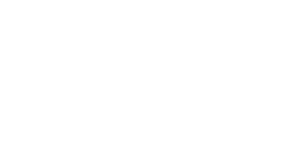

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator


(array([14610., 14669., 14730., 14791., 14853., 14914., 14975.]),
 [Text(14610.0, 0, ''),
  Text(14669.0, 0, ''),
  Text(14730.0, 0, ''),
  Text(14791.0, 0, ''),
  Text(14853.0, 0, ''),
  Text(14914.0, 0, ''),
  Text(14975.0, 0, '')])

In [37]:
# Plot OVP and ML predictions on separate subplots to see more clearly 

%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(8,8))
gs = GridSpec(2,1, figure=fig)


empty_string_labels = ['']*len(X_val.index)


# ax0 = fig.add_subplot(gs[0,0])
ax0 = plt.subplot(gs[0,0])
ax_out0 = ax0.plot(y_val.index,
                    y_val_log,
        #             y_val_erg,
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )
ax_out0 = ax0.plot(y_val.index,
#                     y_val_ovation['model value'].values,
                    y_val_ovation['model value log10(ev/cm2/s)'].values,
                    c = 'r',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='OVATION Prime'
           )
ax_out2 = ax0.scatter(y_val_ovation.index,
#                     y_val_ovation['model value'],
                        y_val_ovation['model value log10(ev/cm2/s)'].values,
                        c = 'r',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )
plt.grid(True)
plt.legend()
ax0.set_xticklabels(empty_string_labels)


ax1 = plt.subplot(gs[1,0],sharex=ax0,sharey=ax0)


ax_out0 = ax1.plot(y_val.index,
                    y_val_log,
        #             y_val_erg,
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )

# Fill between maximum and minimum values
ax1.fill_between(df_CV.index, 
                 df_CV['minimum'].values, 
                 df_CV['maximum'].values, 
#                  c='g',
                 alpha=0.2)

ax_out0 = ax1.plot(df_CV.index,
#                     y_val_ovation['model value'].values,
                    df_CV['median'].values,
                    c = 'g',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='Median PrecipNet'
           )
ax_out2 = ax1.scatter(df_CV.index,
                      df_CV['median'].values,
                        c = 'g',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )

plt.grid(True)
plt.legend()
ax1.set_xticklabels(empty_string_labels)


plt.legend()

plt.xticks(rotation=45)




<IPython.core.display.Javascript object>


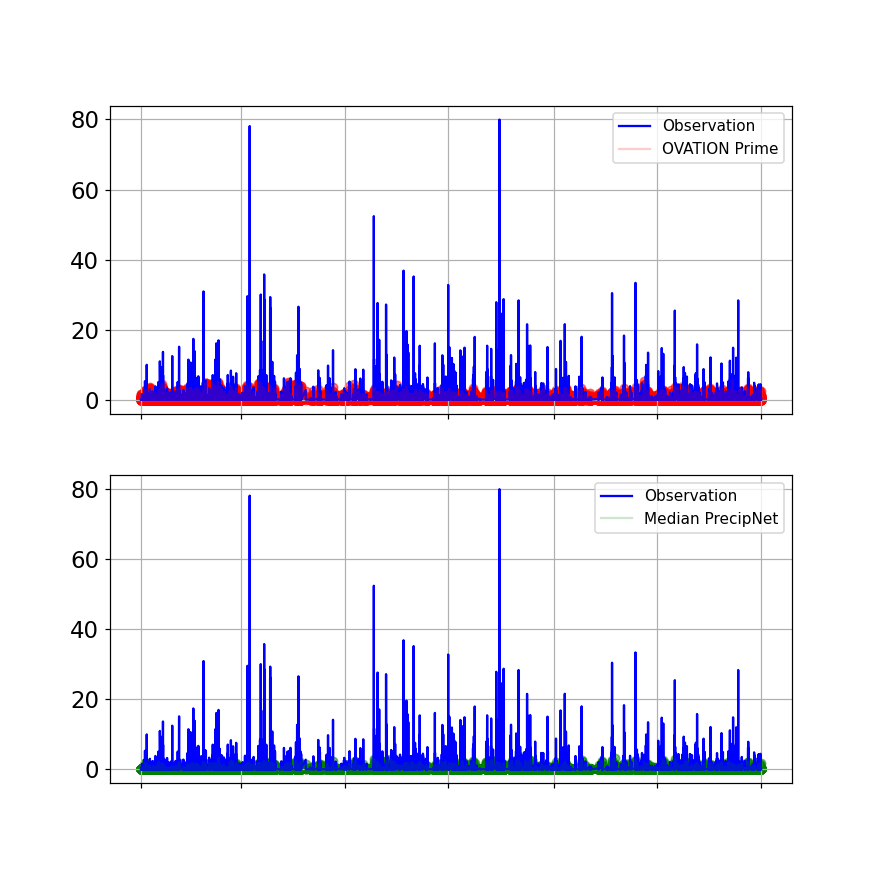

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator


(array([14610., 14669., 14730., 14791., 14853., 14914., 14975.]),
 [Text(14610.0, 0, ''),
  Text(14669.0, 0, ''),
  Text(14730.0, 0, ''),
  Text(14791.0, 0, ''),
  Text(14853.0, 0, ''),
  Text(14914.0, 0, ''),
  Text(14975.0, 0, '')])

In [43]:
# Plot OVP and ML predictions on separate subplots to see more clearly 

%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(8,8))
gs = GridSpec(2,1, figure=fig)


empty_string_labels = ['']*len(X_val.index)


# ax0 = fig.add_subplot(gs[0,0])
ax0 = plt.subplot(gs[0,0])
ax_out0 = ax0.plot(y_val.index,
#                     y_val_log,
                    y_val_erg,
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )
ax_out0 = ax0.plot(y_val.index,
                    y_val_ovation['model value'].values,
#                     y_val_ovation['model value log10(ev/cm2/s)'].values,
                    c = 'r',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='OVATION Prime'
           )
ax_out2 = ax0.scatter(y_val_ovation.index,
                    y_val_ovation['model value'],
#                         y_val_ovation['model value log10(ev/cm2/s)'].values,
                        c = 'r',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )
plt.grid(True)
plt.legend()
ax0.set_xticklabels(empty_string_labels)


ax1 = plt.subplot(gs[1,0],sharex=ax0,sharey=ax0)


ax_out0 = ax1.plot(y_val.index,
#                     y_val_log,
                    y_val_erg,
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )

# Fill between maximum and minimum values
ax1.fill_between(df_CV.index, 
#                  df_CV['minimum'].values, 
                 10**(df_CV['minimum'].values)* erg_eV_factor,
#                  df_CV['maximum'].values, 
                 10**(df_CV['maximum'].values)* erg_eV_factor,
#                  c='g',
                 alpha=0.2)

ax_out0 = ax1.plot(df_CV.index,
#                     df_CV['median'].values,
                    10**(df_CV['median'].values)* erg_eV_factor,
                    c = 'g',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='Median PrecipNet'
           )
ax_out2 = ax1.scatter(df_CV.index,
#                       df_CV['median'].values,
                      10**(df_CV['median'].values)* erg_eV_factor,
                        c = 'g',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )

plt.grid(True)
plt.legend()
ax1.set_xticklabels(empty_string_labels)


plt.legend()

plt.xticks(rotation=45)




In [44]:
df_val_LTIMEs = df_cumulative_LTIMEs[mask_val[0]].copy(deep=True)


In [45]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

<IPython.core.display.Javascript object>


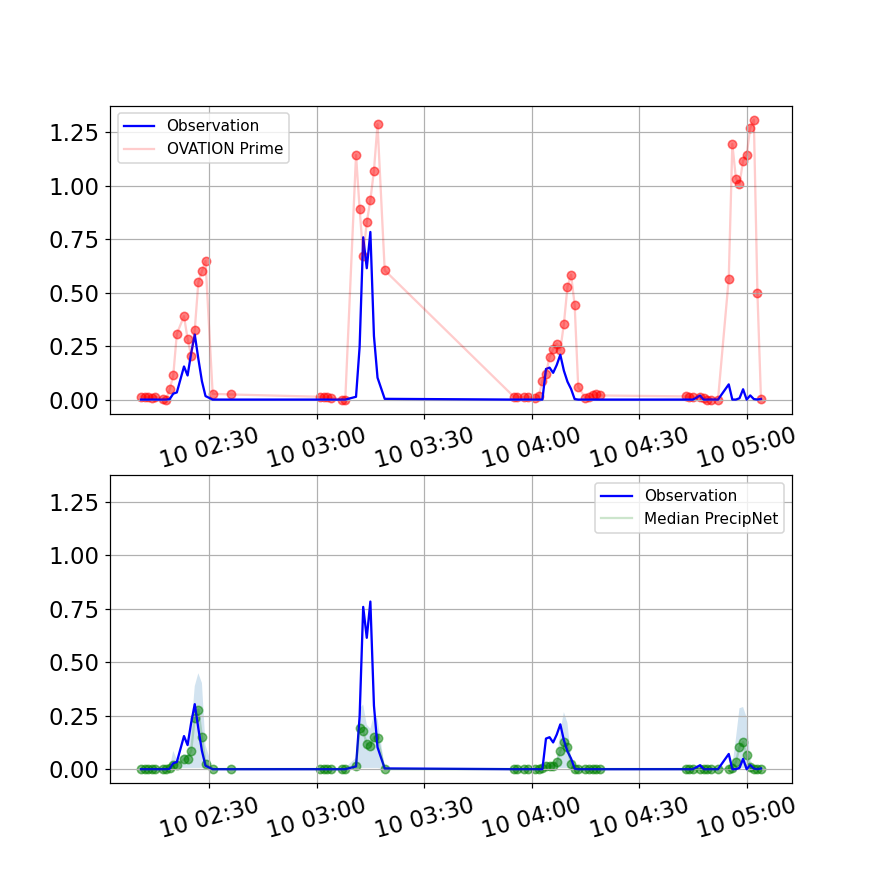

2 (74, 1)


<IPython.core.display.Javascript object>


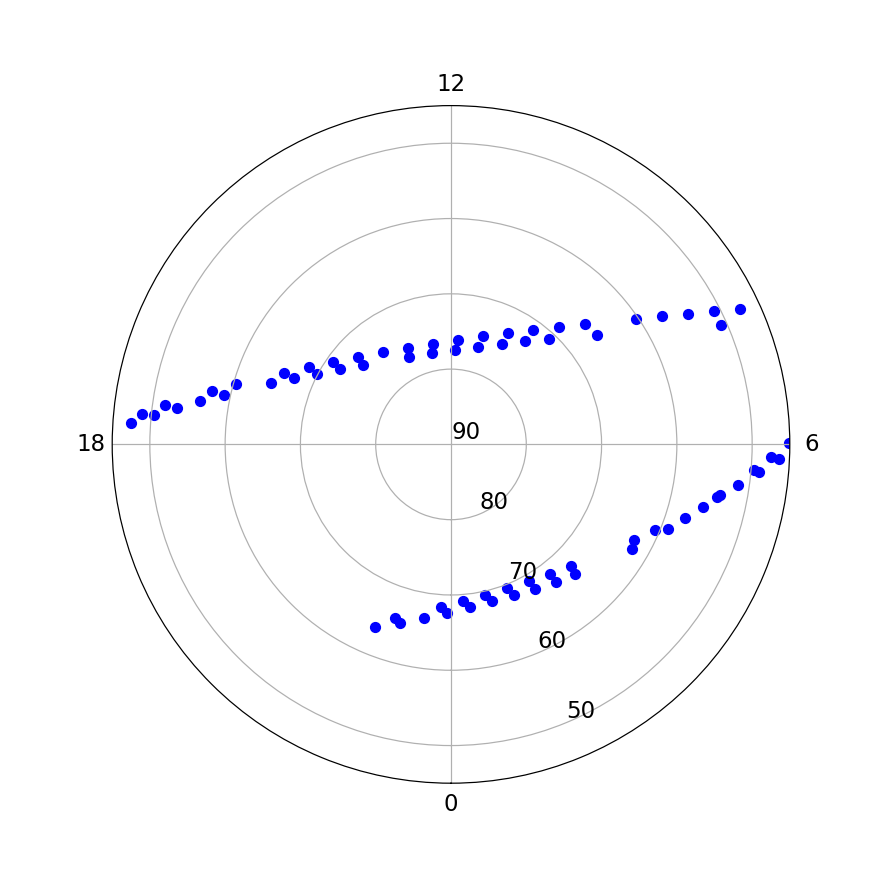

In [46]:
# Plot OVP and ML predictions on separate subplots to see more clearly 

# %matplotlib notebook
import matplotlib.pyplot as plt
# plt.ioff()

fig = plt.figure(figsize=(8,8))
gs = GridSpec(2,1, figure=fig)

datetime_range2 = [datetime.datetime(2010,12,10,1),datetime.datetime(2010,12,10,7)]
zoom_range2 = np.argwhere( (X_val.index>=datetime_range2[0]) & (X_val.index<=datetime_range2[1]) )

print(len(datetime_range2),zoom_range2.shape)
empty_string_labels = ['']*len(X_val.index)
# ax0 = fig.add_subplot(gs[0,0])
ax0 = plt.subplot(gs[0,0])
ax_out0 = ax0.plot(y_val.index[zoom_range2[0][0]:zoom_range2[-1][0]],
#                     y_val_log[zoom_range2[0][0]:zoom_range2[-1][0]],
                    y_val_erg[zoom_range2[0][0]:zoom_range2[-1][0]],
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )

ax_out0 = ax0.plot(y_val.index[zoom_range2[0][0]:zoom_range2[-1][0]],
                    y_val_ovation['model value'].values[zoom_range2[0][0]:zoom_range2[-1][0]],
#                     y_val_ovation['model value log10(ev/cm2/s)'].values[zoom_range2[0][0]:zoom_range2[-1][0]],
                    c = 'r',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='OVATION Prime'
           )
ax_out2 = ax0.scatter(y_val_ovation.index[zoom_range2[0][0]:zoom_range2[-1][0]],
                    y_val_ovation['model value'].values[zoom_range2[0][0]:zoom_range2[-1][0]],
#                         y_val_ovation['model value log10(ev/cm2/s)'].values[zoom_range2[0][0]:zoom_range2[-1][0]],
                        c = 'r',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )
plt.grid(True)
plt.legend()
plt.xticks(rotation=15)

# ax0.set_xticklabels(empty_string_labels)


ax1 = plt.subplot(gs[1,0],sharex=ax0,sharey=ax0)


ax_out0 = ax1.plot(y_val.index[zoom_range2[0][0]:zoom_range2[-1][0]],
#                     y_val_log[zoom_range2[0][0]:zoom_range2[-1][0]],
                    y_val_erg[zoom_range2[0][0]:zoom_range2[-1][0]],
                    c = 'b',
                    alpha = 1,
                    label='Observation'
                  )

# Fill between maximum and minimum values
ax1.fill_between(df_CV.index[zoom_range2[0][0]:zoom_range2[-1][0]], 
                 10**(df_CV['minimum'].values[zoom_range2[0][0]:zoom_range2[-1][0]])* erg_eV_factor,
                 10**(df_CV['maximum'].values[zoom_range2[0][0]:zoom_range2[-1][0]])* erg_eV_factor,
#                  c='g',
                 alpha=0.2)

ax_out0 = ax1.plot(df_CV.index[zoom_range2[0][0]:zoom_range2[-1][0]],
                    10**(df_CV['median'].values[zoom_range2[0][0]:zoom_range2[-1][0]])* erg_eV_factor,
                    c = 'g',#c = [240./255.,200./255.,8./255.,]
                    alpha =0.2,
                    label='Median PrecipNet'
           )
ax_out2 = ax1.scatter(df_CV.index[zoom_range2[0][0]:zoom_range2[-1][0]],
                      10**(df_CV['median'].values[zoom_range2[0][0]:zoom_range2[-1][0]])* erg_eV_factor,
                        c = 'g',#c = [240./255.,200./255.,8./255.,]
                        alpha = 0.5,
                        s=30,
                        label='_nolegend_'
           )

plt.grid(True)
plt.legend()
# ax1.set_xticklabels(empty_string_labels)


plt.legend()

plt.xticks(rotation=15)





#----------------------------------------------------------------------------------------------------------------
# POLAR PLOT

fig = plt.figure(figsize=(8,8))
gs = GridSpec(1,1, figure=fig)
ax0 = plt.subplot(gs[0,0],polar=True)

ax_out0 = ax0.scatter(df_val_LTIMEs.values[zoom_range2[0][0]:zoom_range2[-1][0]]*15.* (np.pi/180.), 
                      90. - X_val['SC_AACGM_LAT'][zoom_range2[0][0]:zoom_range2[-1][0]],
                      s = 40,
                      c = 'b')

# define your axis limits
ax0.set_ylim([0,45])

# Set the radius labels
ax0.set_yticks(np.arange(0,50,10))  # less radial ticks
ax0.set_yticklabels(90 - np.arange(0,50,10))  # less radial ticks

# Set the circumference labels
ax0.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
ax0.set_xticklabels(('0','6','12','18'))      

ax0.grid(True)
ax0.set_theta_zero_location("S")

#----------------------------------------------------------------------------------------------------------------


plt.show()

In [47]:
df_metrics_CV_val

df_metrics_CV_val_median = df_metrics_CV_val.median(axis=0)
df_metrics_CV_val_minimum = df_metrics_CV_val.min(axis=0)
df_metrics_CV_val_maximum = df_metrics_CV_val.max(axis=0)
df_metrics_CV_val_mean = df_metrics_CV_val.mean(axis=0)
df_metrics_CV_val_stdev = df_metrics_CV_val.std(axis=0)

for i in df_metrics_CV_val_median.index:
    if i == 'iteration':
        continue
    print('{}   {:.3F} +/- {:.2F}'.format(i,df_metrics_CV_val_median[i],df_metrics_CV_val_stdev[i]))


MAE   0.557 +/- 0.36
MSE   0.580 +/- 0.77
RMSE   0.762 +/- 0.33
RAE   0.403 +/- 0.26
RSE   0.247 +/- 0.33
RSQ   0.753 +/- 0.33
linear slope   0.721 +/- 0.30
linear intercept   2.614 +/- 2.94


In [48]:
df_metrics_CV_val

iteration       MAE       MSE      RMSE       RAE       RSE        RSQ  \
0         0   0.55377  0.578064  0.760305  0.400106  0.246506   0.753494   
1         1   1.42459   2.43838   1.56153   1.02928   1.03981 -0.0398117   
2         2  0.558648  0.580132  0.761664   0.40363  0.247388   0.752612   
3         3  0.555709  0.580003  0.761579  0.401507  0.247334   0.752666   
4         4  0.578184  0.604307  0.777372  0.417746  0.257697   0.742303   
5         5  0.617967  0.643005  0.801876  0.446489    0.2742     0.7258   
6         6   1.41573   2.40809    1.5518   1.02289   1.02689 -0.0268937   
7         7  0.544803  0.575671   0.75873  0.393628  0.245486   0.754514   
8         8  0.551668  0.575788  0.758807  0.398587  0.245536   0.754464   
9         9  0.553889   0.57913  0.761006  0.400192  0.246961   0.753039   

  linear slope linear intercept  
0     0.726623           2.5223  
1            0          9.62277  
2     0.717246          2.64478  
3     0.724339          2.58253  
4     0.703443          2.83721  
5     0.672387          3.21832  
6            0          9.56835  
7     0.743226            2.436  
8     0.744771          2.43035  
9     0.729485          2.55525

In [49]:
df_CV.columns

Index(['CV0', 'CV1', 'CV2', 'CV3', 'CV4', 'CV5', 'CV6', 'CV7', 'CV8', 'CV9',
       'median', 'minimum', 'maximum', 'stdev'],
      dtype='object')

<IPython.core.display.Javascript object>


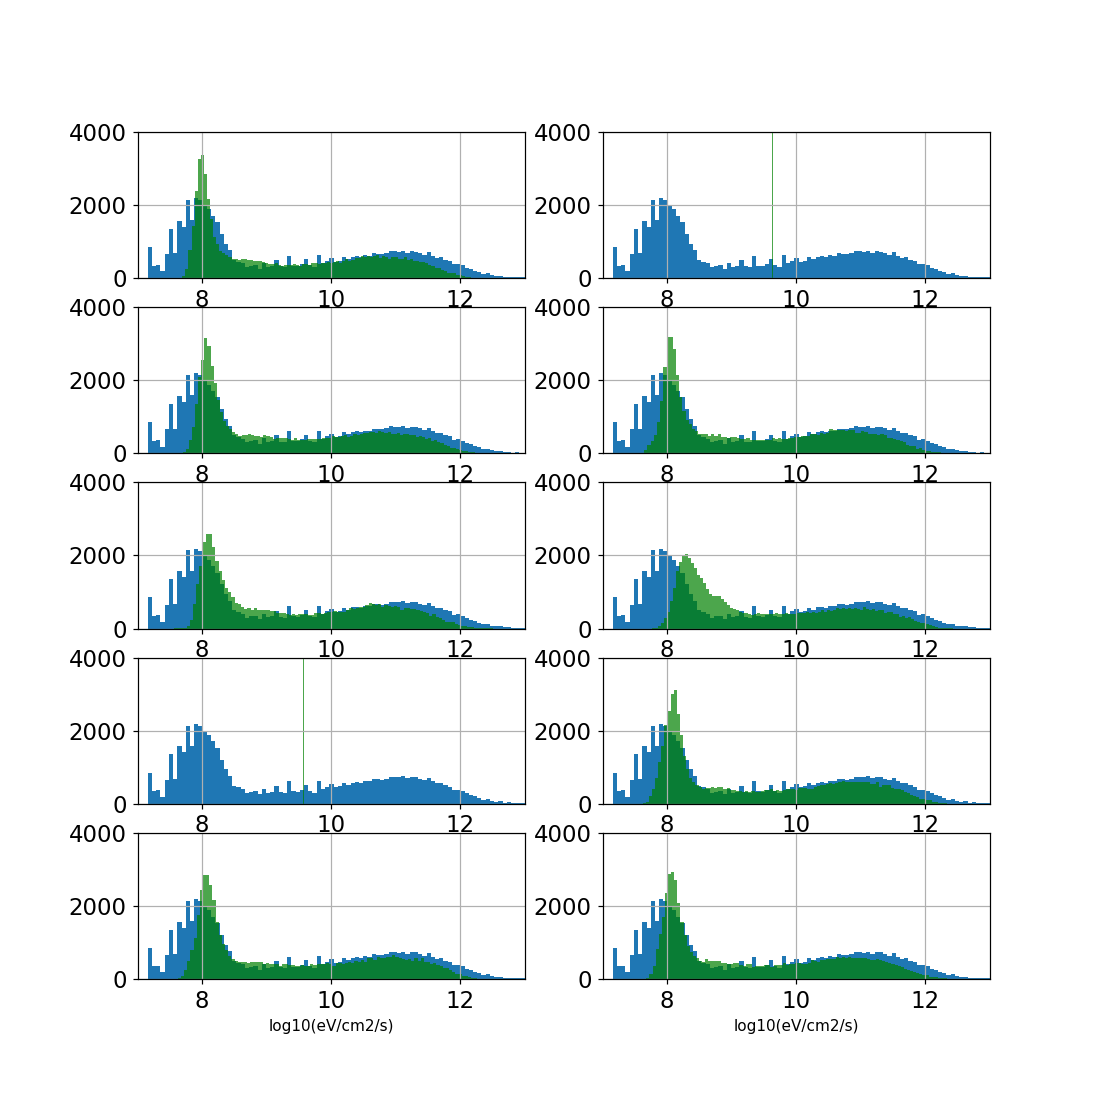

In [50]:
num_bins_plot = 100
fig = plt.figure(figsize=(10,10))
gs = GridSpec(5,2, figure=fig)
    
ctr = 0
for i in df_CV_columns:


    ax0 = fig.add_subplot(gs[ctr])
    ax0.hist(y_val_log,
             label= 'Observed validation',
             bins = num_bins_plot)
    # plt.ylabel('Validation: obs')
    plt.ylim([0,4000])
    plt.xlim([7,13])
    plt.grid(True)
    plt.xlabel('log10(eV/cm2/s)')


    ax0.hist(
             df_CV[i].values,
             bins = num_bins_plot,
             alpha = 0.7,
             color='g',
             label='NN validation prediction')

#     plt.legend()
    
    ctr +=1

<IPython.core.display.Javascript object>


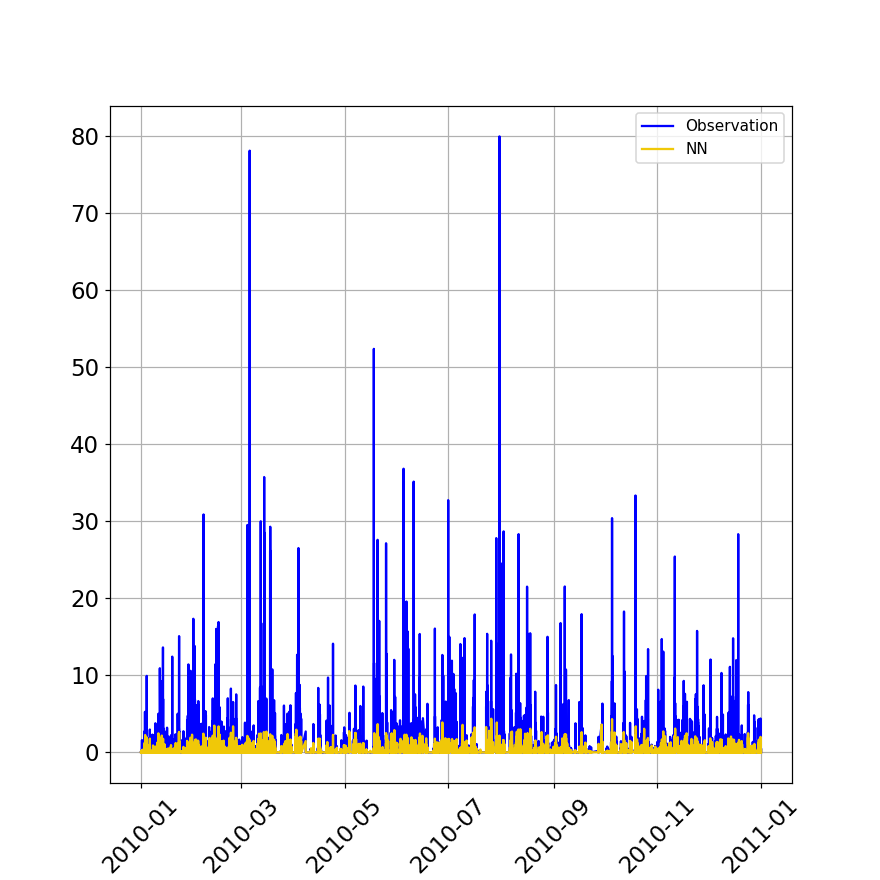

(array([14610., 14669., 14730., 14791., 14853., 14914., 14975.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

In [51]:
# Plot OVP and ML predictions on separate subplots to see more clearly 

%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(8,8))
gs = GridSpec(1,1, figure=fig)


empty_string_labels = ['']*len(X_val.index)


# ax0 = fig.add_subplot(gs[0,0])
ax0 = plt.subplot(gs[0,0])
ax_out0 = ax0.plot(X_val.index,
#             y_val_log,
            y_val_erg,
            c = 'b',
            alpha = 1,
            label='Observation'
           )
ax_out1 = ax0.plot(X_val.index,
            10**(df_CV['CV7'].values) * (1.60218e-12),
            c = [240./255.,200./255.,8./255.,],
            alpha =1,
            label='NN'
           )

plt.grid(True)
plt.legend()
# ax2.set_xticklabels(empty_string_labels)


plt.legend()

plt.xticks(rotation=45)




<IPython.core.display.Javascript object>


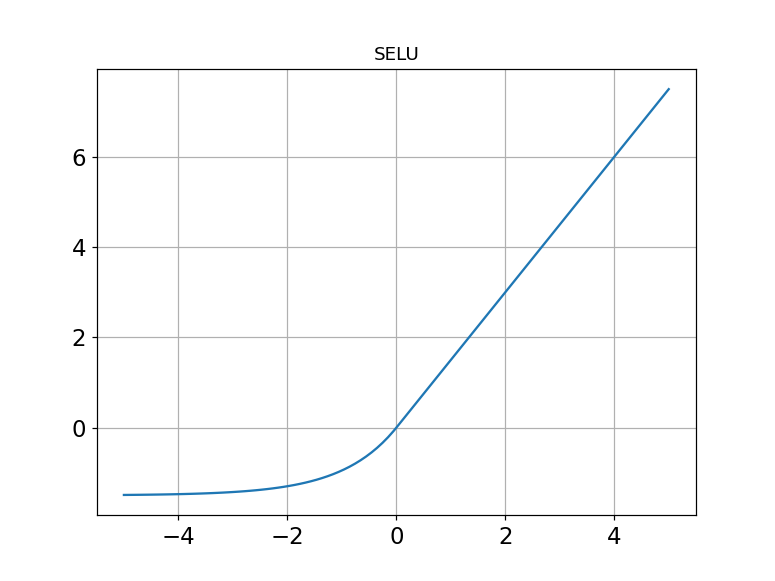

Text(0.5, 1.0, 'SELU')

In [52]:

def fun(x,lamb,alph):
    if x <= 0:
        y = lamb* ((alph)*np.exp(x) - (alph))
    elif x>0:
        y = lamb*x
    return y
    
vfun = np.vectorize(fun)
x = np.linspace(-5,5,100)
y = vfun(x,1.5,1)

plt.figure()
plt.plot(x,y)
plt.grid(True)
plt.title('SELU')
